# Risk evaluation for retail banks

## Introduction

The goal of this project is to work on a POC to provide risk evaluation as a service for retail banks. For this purpose, a dataset containing information about the loaning history will be used. Based on this information, we will try to predict whether or not a loaner is likely to have difficulty repaying the loan. This way, the banks can be more confident in decisions as to whom the loans should be granted or not. In addition, we will investigate whether one of the features, which is normally coming from external sources, could be implied from the data we have at hand. This way, the banks could use only the data they have locally and save costs.

The project is divided into 3 notebooks:
* Exploratory data analysis and feature engineering
* Loan default prediction and hyperparameter tuning
* External source 3 prediction and hyperparameter tuning

In this notebook, we will perform data cleaning and EDA to get insights into different data and how it relates to the main target - default prediction. Finally, feature engineering will be performed. 

## Setup

In [1]:
import numpy as np
import pandas as pd
import phik

import seaborn as sns
import matplotlib.pyplot as plt
import math

import pickle as pkl

import warnings
warnings.filterwarnings("ignore")

from helpers import helpers_eda as h

## Data description

The dataset we have available contains multiple files. Here is a brief description of each table:

**application_{train|test}.csv**

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample. In this project, we will only use train data because test data does not provide an output variable.

**bureau.csv**

All client's previous credits provided by other financial institutions were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as the number of credits the client had in the Credit Bureau before the application date.

**bureau_balance.csv**

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to the Credit Bureau – i.e the table has (# loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

**POS_CASH_balance.csv**

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (# loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

**credit_card_balance.csv**

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

**previous_application.csv**

All previous applications for Home Credit loans of clients who have loans in our sample. There is one row for each previous application related to loans in our data sample.

**installments_payments.csv**

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. There is a) one row for every payment that was made plus b) one row each for a missed payment. One row is equivalent to one payment of one instalment OR one instalment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

**HomeCredit_columns_description.csv**

This file contains descriptions for the columns in the various data files.

## Data preprocessing and exploratory analysis

First, we will inspect the content of provided tables and clean the data. For this purpose, the pandas pipeline with the following steps will be applied for each dataset:

* Check the shape of the table
* Check missing values in each column. If there are missing values, plot the percentage of missing values in each column in descending order
* Drop duplicate rows
* Drop empty rows (excluding ID column)
* Print the adjusted table shape

Furthermore, we will perform an exploratory analysis of provided variables. Mainly, we will focus on how the features relate to the output variable. For each table, features will be separated into numeric and categorical. Then, correlations are calculated between these features and the output. Finally, for highly correlated features we will investigate the value distribution between non-default and default groups.

### Application data

In [2]:
train_data = pd.read_csv('application_train.csv')

train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


As the name identifies, the first table contains training data for predicting loan outcomes and features that are available for the current application. The TARGET variable contains the output feature: 1 for loans with payment difficulties and 0 for all other cases. Also, we see that some of the features have numeric values while they are categorical. Therefore, for each table, we will define the categorical and numeric feature lists and save them for feature building.

Next, we perform data cleaning.

Original dataframe shape (307511, 122)
No missing values in ['sk_id_curr', 'target', 'name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children', 'amt_income_total', 'amt_credit', 'name_income_type', 'name_education_type', 'name_family_status', 'name_housing_type', 'region_population_relative', 'days_birth', 'days_employed', 'days_registration', 'days_id_publish', 'flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'region_rating_client', 'region_rating_client_w_city', 'weekday_appr_process_start', 'hour_appr_process_start', 'reg_region_not_live_region', 'reg_region_not_work_region', 'live_region_not_work_region', 'reg_city_not_live_city', 'reg_city_not_work_city', 'live_city_not_work_city', 'organization_type', 'flag_document_2', 'flag_document_3', 'flag_document_4', 'flag_document_5', 'flag_document_6', 'flag_document_7', 'flag_document_8', 'flag_document_9', 'flag_document_10', 'flag_document_11', 'flag_docume

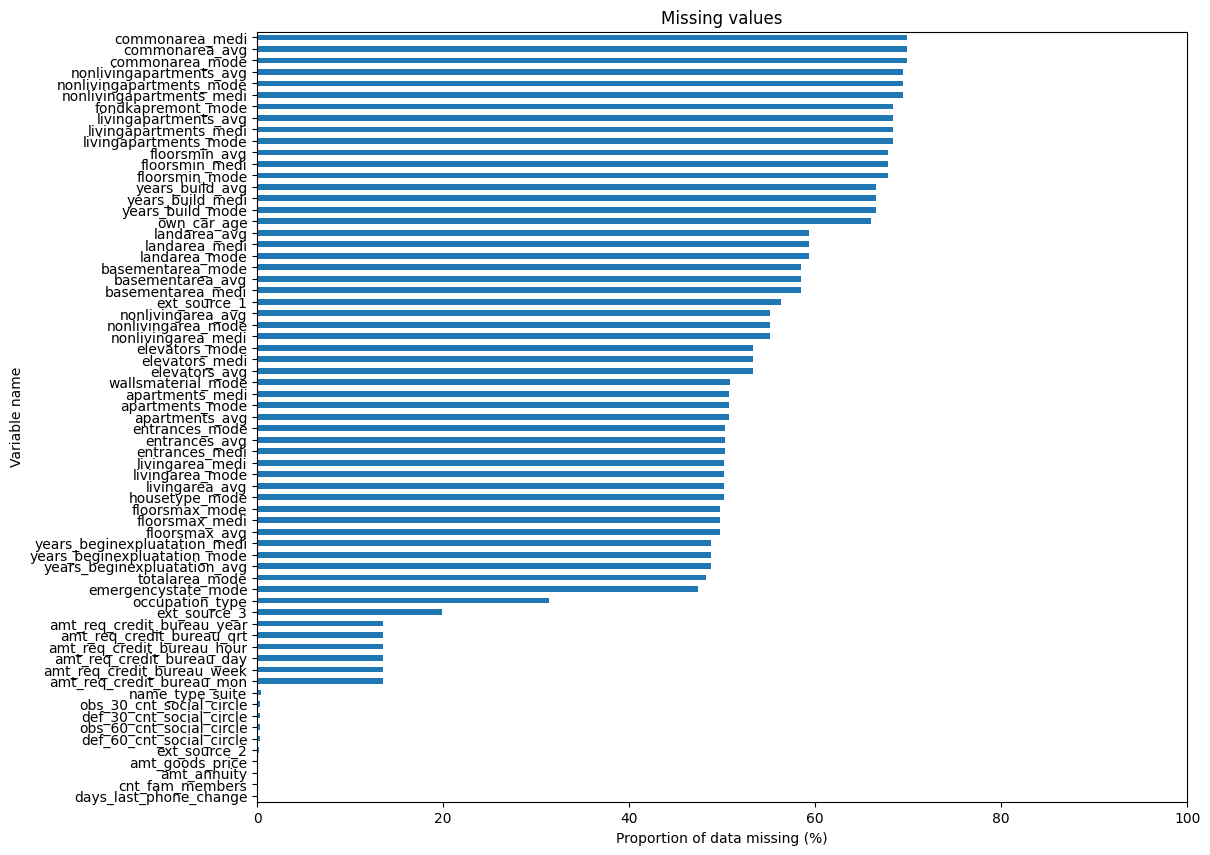

In [3]:
plt.figure(figsize=(12, 10))

train_data_clean = (train_data
                    .pipe(h.print_shape)
                    .pipe(h.copy_data)
                    .pipe(h.lower_column_names)
                    .pipe(h.check_missing_values)
                    .pipe(h.remove_duplicate_rows)
                    .pipe(h.remove_empty_rows)
                    .pipe(h.print_output_shape)
                    )

We see that there are quite some features with a lot of missing data values. We will make sure to adjust for that when building models. 

We will inspect how the target variable is distributed.

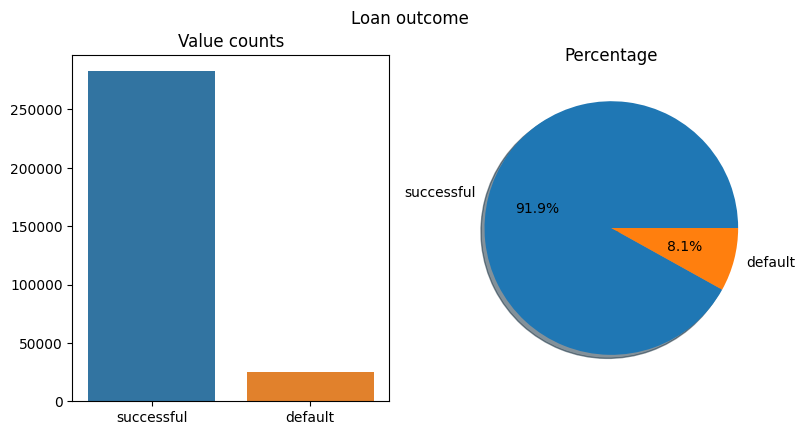

In [4]:
h.plot_outcome_distribution(train_data_clean, 'target', ['successful', 'default'])

Around 8% of the loans have defaulted which shows that this will be an imbalanced classification problem.

We will take a look at how these or similar features are distributed between defaulters and non-defaulters in correlating categorical and numeric features.

#### Numeric variables

First, we will separate categorical from numeric features.

In [5]:
categorical_train = ['sk_id_curr', 'target', 'flag_mobil', 'flag_emp_phone', 
                     'flag_work_phone', 'flag_cont_mobile',
                     'flag_phone', 'flag_email',
                     'region_rating_client',
                     'region_rating_client_w_city',
                     'reg_region_not_live_region', 
                     'reg_region_not_work_region', 
                     'live_region_not_work_region',
                     'reg_city_not_live_city', 
                     'reg_city_not_work_city',
                     'live_city_not_work_city',
                     'flag_document_2', 'flag_document_3', 
                     'flag_document_4', 'flag_document_5',
                     'flag_document_6', 'flag_document_7',
                     'flag_document_8', 'flag_document_9', 
                     'flag_document_10', 'flag_document_11', 
                     'flag_document_12', 'flag_document_13', 
                     'flag_document_14', 'flag_document_15', 
                     'flag_document_16', 'flag_document_17', 
                     'flag_document_18', 'flag_document_19', 
                     'flag_document_20', 'flag_document_21'] \
                      + train_data_clean.dtypes[
                      train_data_clean.dtypes
                      == 'object'].index.tolist()

numeric_train = train_data_clean.columns[~train_data_clean.columns.isin(categorical_train)].tolist()

Deriving highest correlations between target and numeric features.

In [6]:
h.top_numeric_correlations(train_data_clean, 'target', numeric_train, 10)

,target
ext_source_3,0.178919
ext_source_2,0.160472
ext_source_1,0.155317
days_birth,0.078239
days_last_phone_change,0.055218
days_id_publish,0.051457
days_employed,0.044932
floorsmax_avg,0.044003
floorsmax_medi,0.043768
floorsmax_mode,0.043226


We will look at boxplots seperated by loan outcome.

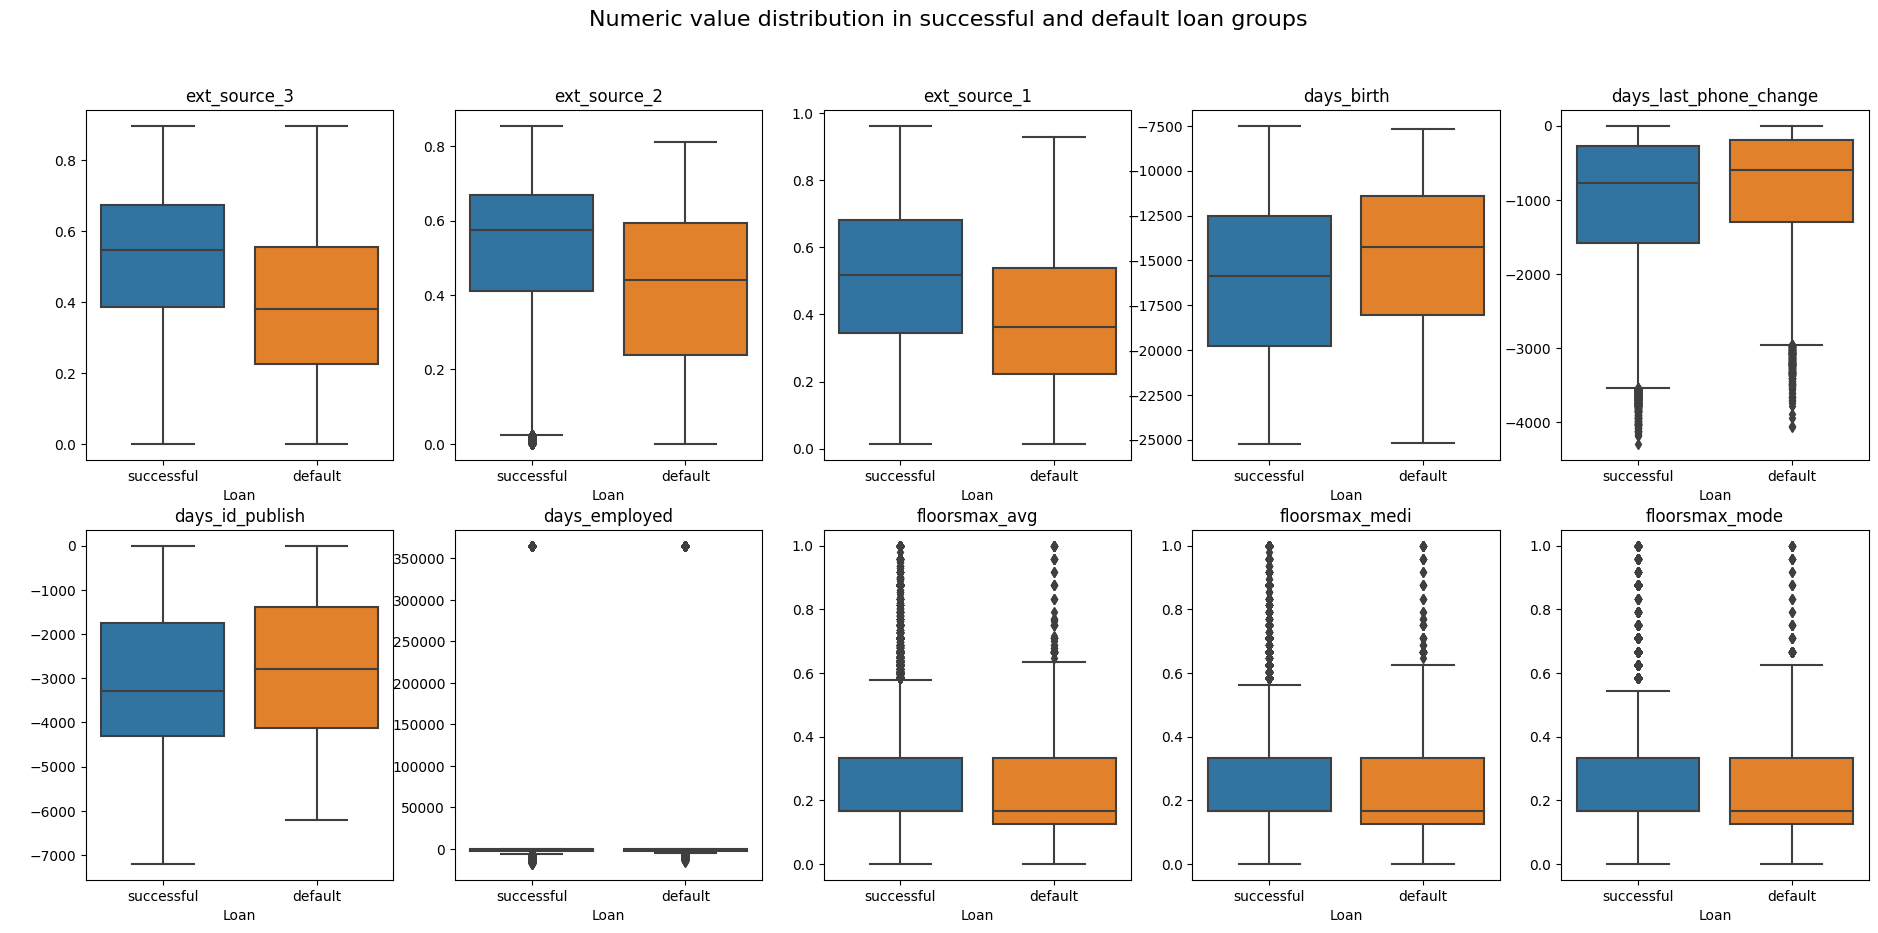

In [7]:
h.plot_boxplots(train_data_clean, 'target', 
                    ['ext_source_3', 'ext_source_2',
                     'ext_source_1', 'days_birth', 
                     'days_last_phone_change', 
                     'days_id_publish', 'days_employed', 
                     'floorsmax_avg', 'floorsmax_medi',
                     'floorsmax_mode'], 
                      2)

The distributions of floormax variables are almost identical which likely identifies a high correlation. We will take care of it when building the models. 

Furthermore, the graphs reveal some suspicious values of days employed: 365243 days would result in 1000 years which is not a realistic employment time. We will adjust for this. Furthermore, from days variables will be converted to years.

In [8]:
error_days = train_data_clean.days_employed == 365243
train_data_clean.loc[error_days, 'days_employed'] = np.nan

train_data_clean['years_employed'] = train_data_clean['days_employed'] * -1 / 365
train_data_clean['age'] = round(train_data_clean.days_birth * -1 / 365).astype('int')

numeric_train.append('years_employed')
numeric_train.append('age')

Similarly, we will look at kernel density estimates.

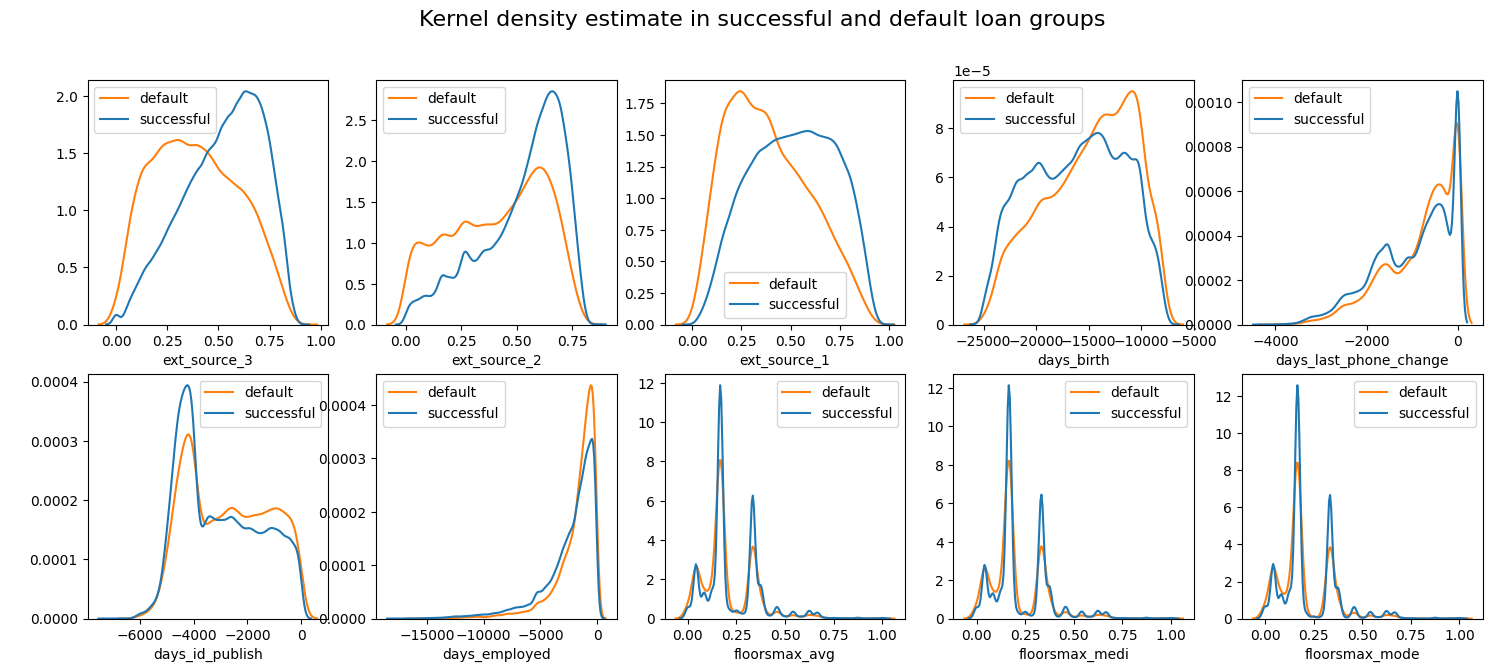

In [9]:
h.plot_density(train_data_clean, 'target', 
            ['ext_source_3', 'ext_source_2',
             'ext_source_1', 'days_birth', 
             'days_last_phone_change', 
             'days_id_publish', 'days_employed', 
             'floorsmax_avg', 'floorsmax_medi',
             'floorsmax_mode'], 
              2)

#### Categorical variables

For categorical data, we will also check correlations and how the different categories fall within non-default and default groups.

In [10]:
h.top_categorical_correlations(train_data_clean[categorical_train], 'target', 5)

interval columns not set, guessing: ['sk_id_curr', 'target', 'flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'region_rating_client', 'region_rating_client_w_city', 'reg_region_not_live_region', 'reg_region_not_work_region', 'live_region_not_work_region', 'reg_city_not_live_city', 'reg_city_not_work_city', 'live_city_not_work_city', 'flag_document_2', 'flag_document_3', 'flag_document_4', 'flag_document_5', 'flag_document_6', 'flag_document_7', 'flag_document_8', 'flag_document_9', 'flag_document_10', 'flag_document_11', 'flag_document_12', 'flag_document_13', 'flag_document_14', 'flag_document_15', 'flag_document_16', 'flag_document_17', 'flag_document_18', 'flag_document_19', 'flag_document_20', 'flag_document_21']


,target
occupation_type,0.090029
organization_type,0.089164
name_income_type,0.084831
reg_city_not_work_city,0.079946
flag_emp_phone,0.072087


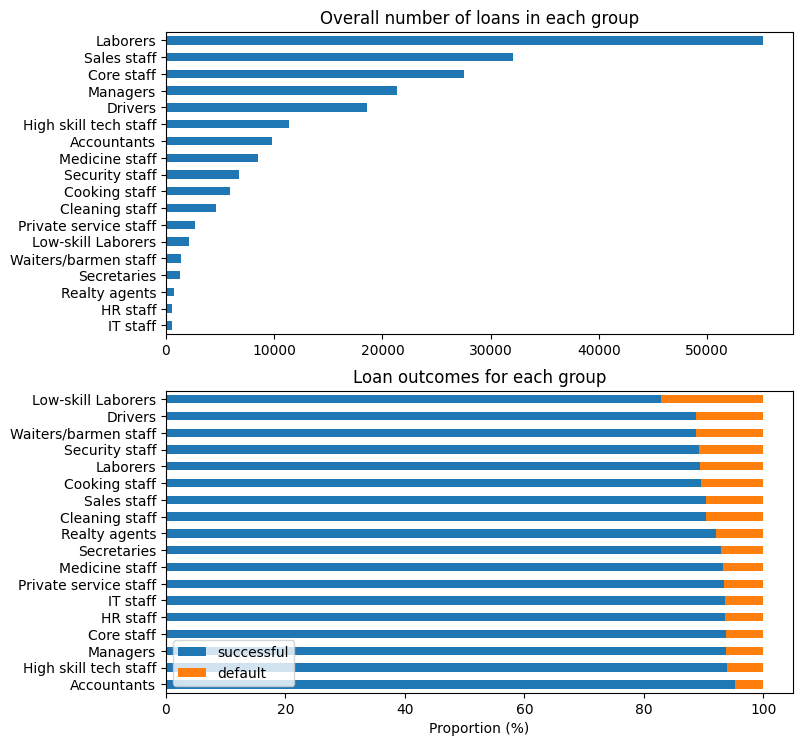

In [11]:
h.ploth_category_counts_percentage(train_data_clean, 'occupation_type', 'target')

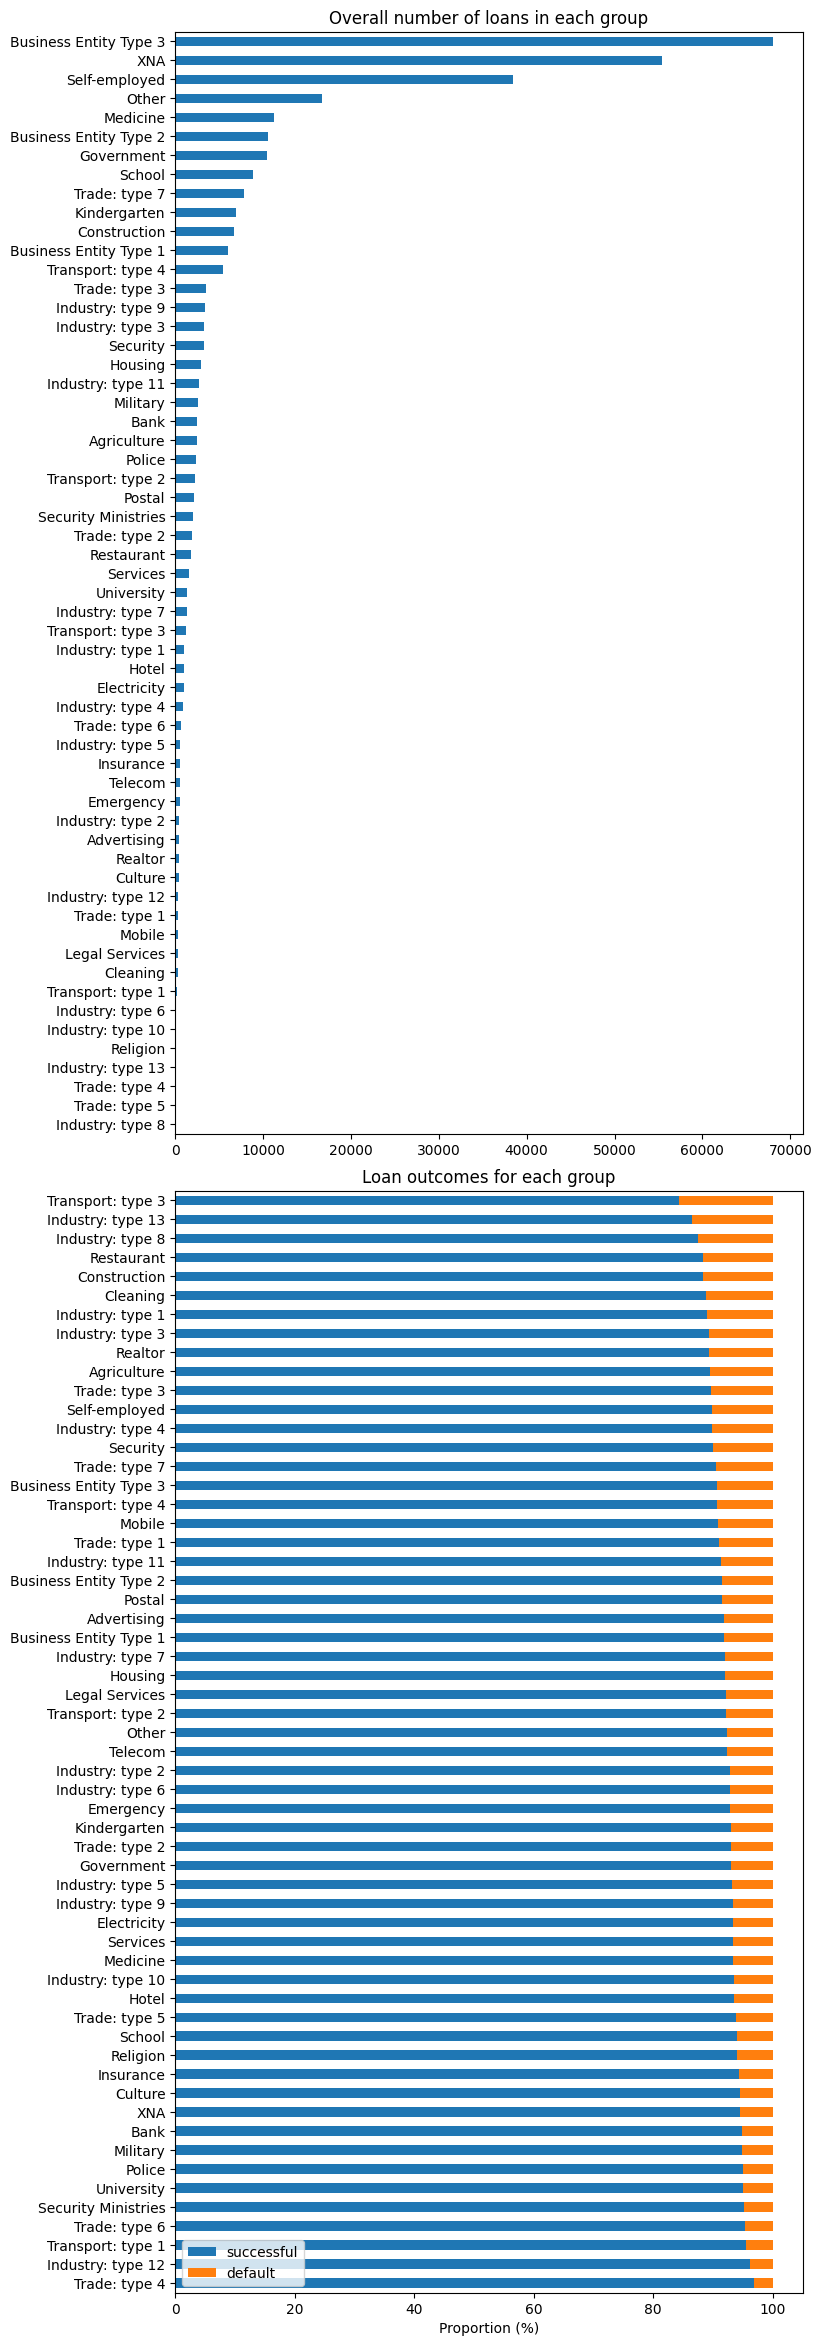

In [12]:
h.ploth_category_counts_percentage(train_data_clean, 'organization_type', 'target')

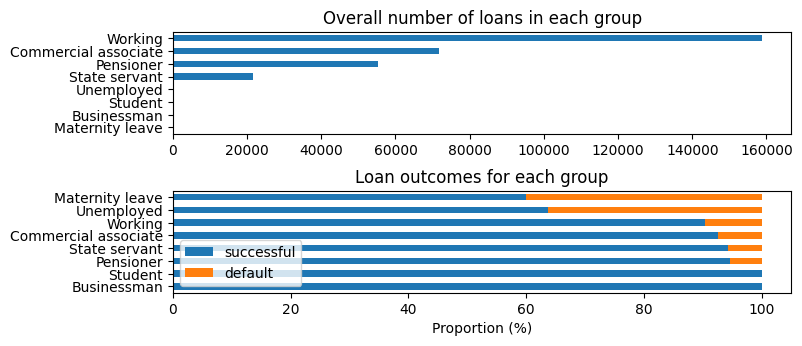

In [13]:
h.ploth_category_counts_percentage(train_data_clean, 'name_income_type', 'target')

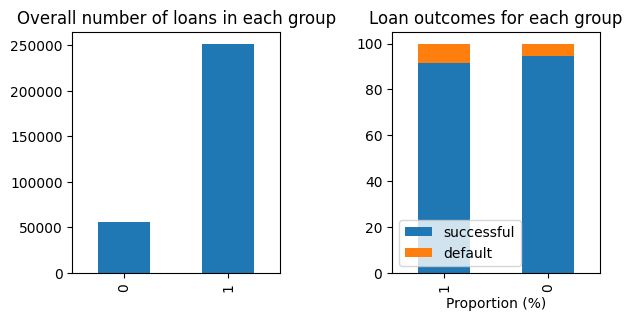

In [14]:
h.plotv_category_counts_percentage(train_data_clean, 'flag_emp_phone', 'target')

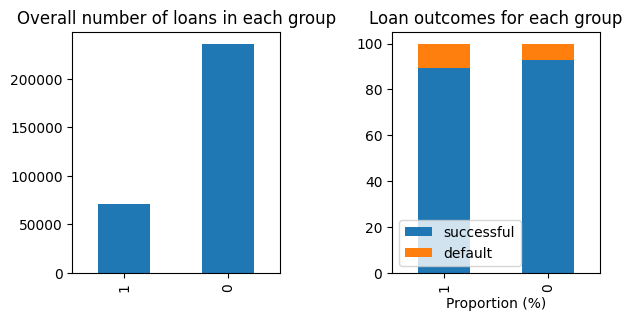

In [15]:
h.plotv_category_counts_percentage(train_data_clean, 'reg_city_not_work_city', 'target')

#### Insights

* The highest correlating numerical features with the target variable were those related to external sources, age, duration of work as well as own real estate features.
* External source values tend to be lower than the default group. Differences in other highly correlated numeric features are less clear.
* The highest correlating categorical features were related to occupation, organization income type etc.
* The biggest proportion of the defaulters are Low-skilled Laborers, Transport Type 3, and Maternity leave subgroups. 

### Bureau data

This dataset shows all client's previous credits provided by **other** financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

In [16]:
bureau = pd.read_csv('bureau.csv')

bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


First, we will apply the general preprocessing pipeline.

Original dataframe shape (1716428, 17)
No missing values in ['sk_id_curr', 'sk_id_bureau', 'credit_active', 'credit_currency', 'days_credit', 'credit_day_overdue', 'cnt_credit_prolong', 'amt_credit_sum_overdue', 'credit_type', 'days_credit_update']
Dataframe shape after cleaning (1716428, 17)


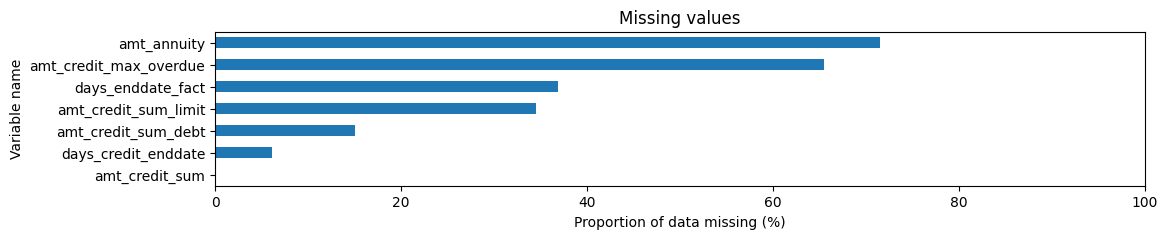

In [17]:
plt.figure(figsize=(12, 2))

bureau_clean = (bureau
                .pipe(h.print_shape)
                .pipe(h.copy_data)
                .pipe(h.lower_column_names)
                .pipe(h.check_missing_values)
                .pipe(h.remove_duplicate_rows)
                .pipe(h.remove_empty_rows)
                .pipe(h.print_output_shape)
                )

The bureau has multiple entries for each costumer id. We will check how many unique costumer there are.

In [18]:
bureau_clean.sk_id_curr.nunique()

305811

In [19]:
train_data_clean.sk_id_curr.nunique()

307511

In comparison to the application dataframe, the bureau dataset has fewer unique customer ids.
We will merge the data with the target variable and investigate the associations.

#### Numeric variables

In [20]:
bureau_merged = train_data_clean[['sk_id_curr', 'target']] \
                .merge(bureau_clean, on='sk_id_curr', how='left')

categorical_bureau = ['target','credit_active',
                     'credit_currency', 'credit_type']

numeric_bureau = ['days_credit', 'credit_day_overdue',
                'days_credit_enddate', 'days_enddate_fact', 
                'amt_credit_max_overdue',
                'cnt_credit_prolong', 'amt_credit_sum',
                'amt_credit_sum_debt',
                'amt_credit_sum_limit', 'amt_credit_sum_overdue',
                'days_credit_update', 'amt_annuity']

h.top_numeric_correlations(bureau_merged, 'target', numeric_bureau, 5)

,target
days_credit,0.061556
days_credit_update,0.041076
days_enddate_fact,0.039057
days_credit_enddate,0.026497
amt_credit_sum,0.010606


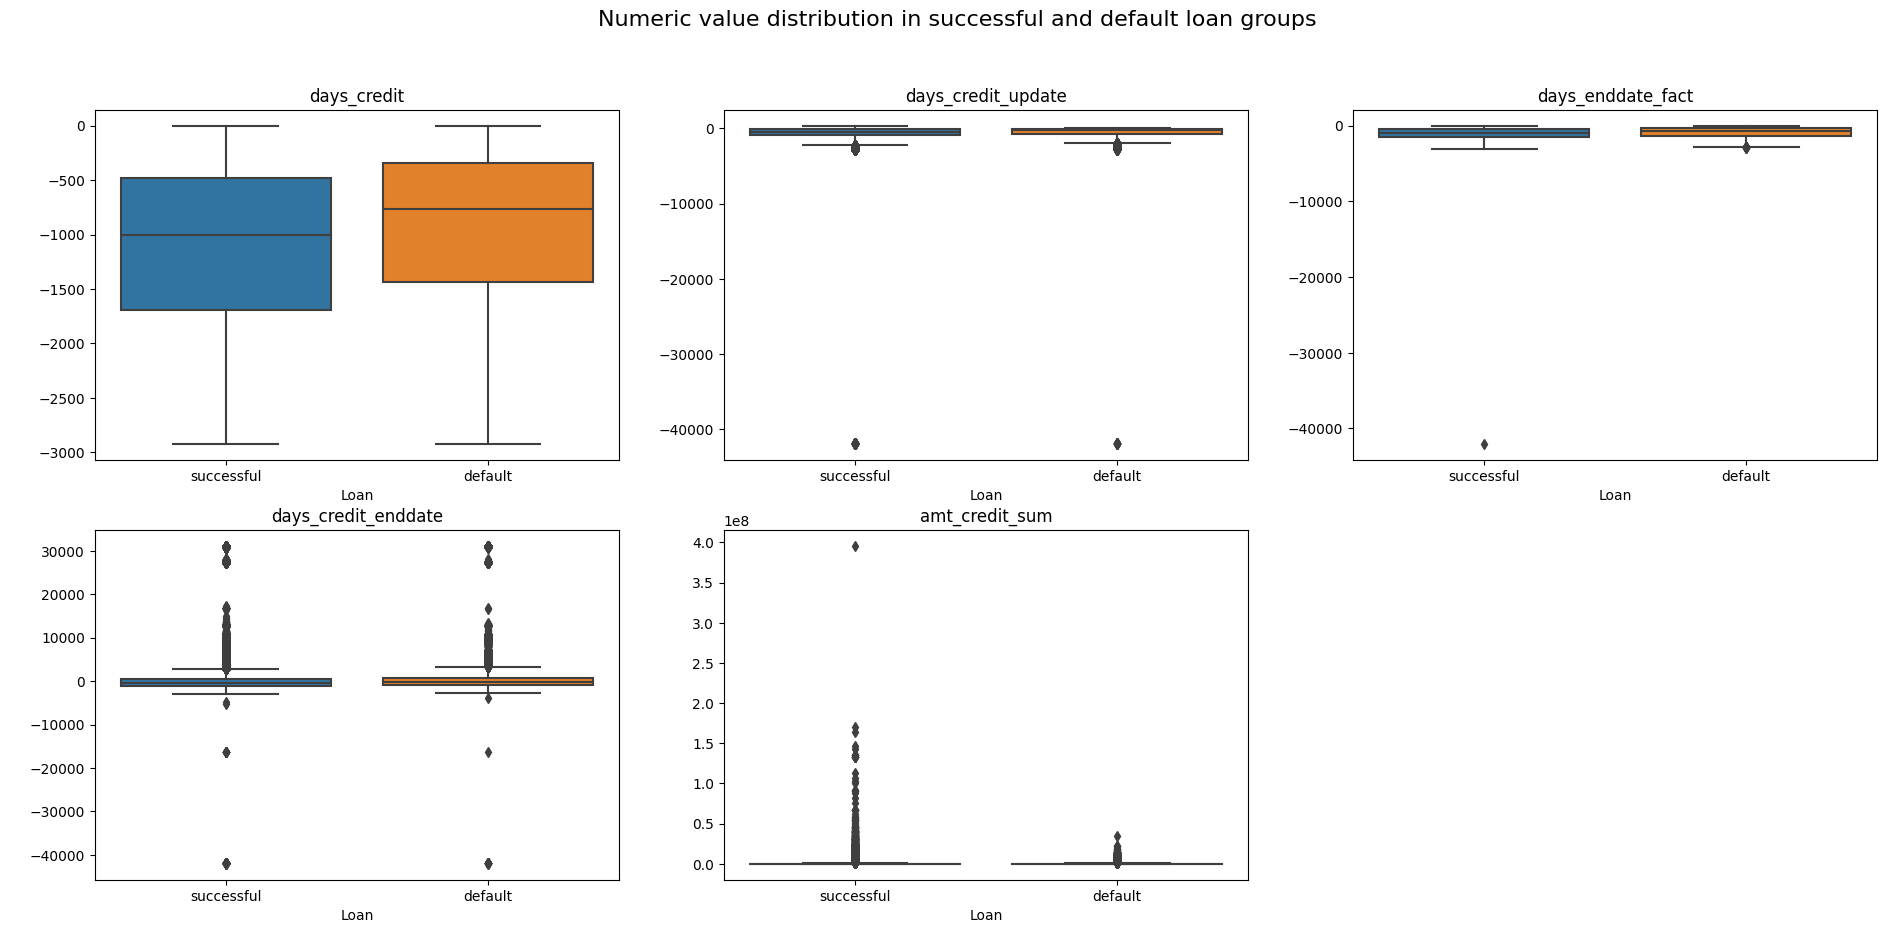

In [21]:
h.plot_boxplots(bureau_merged, 'target', 
            ['days_credit', 'days_credit_update',
             'days_enddate_fact', 'days_credit_enddate', 
             'amt_credit_sum'], 
              2)

We see again that there are some outlier values for the days variables - there is information about loans that ended more than 100 years ago. Alternatively, these also could be some erroneous data entries. As these entries are questionable and impossible to confirm, we will replace the older than 50 years' application values with nan values.

In [22]:
bureau_merged.loc[bureau_merged['days_credit_enddate'] \
                  < -50 * 365, 'days_credit_enddate'] = np.nan

bureau_merged.loc[bureau_merged['days_enddate_fact'] \
                  < -50 * 365, 'days_enddate_fact'] = np.nan

bureau_merged.loc[bureau_merged['days_credit_update'] \
                  < -50 * 365, 'days_credit_update'] = np.nan

error_amount = bureau_merged.amt_credit_sum == 396000000
bureau_merged.loc[error_amount, 'amt_credit_sum'] = np.nan

With adjusted data we check KDE.

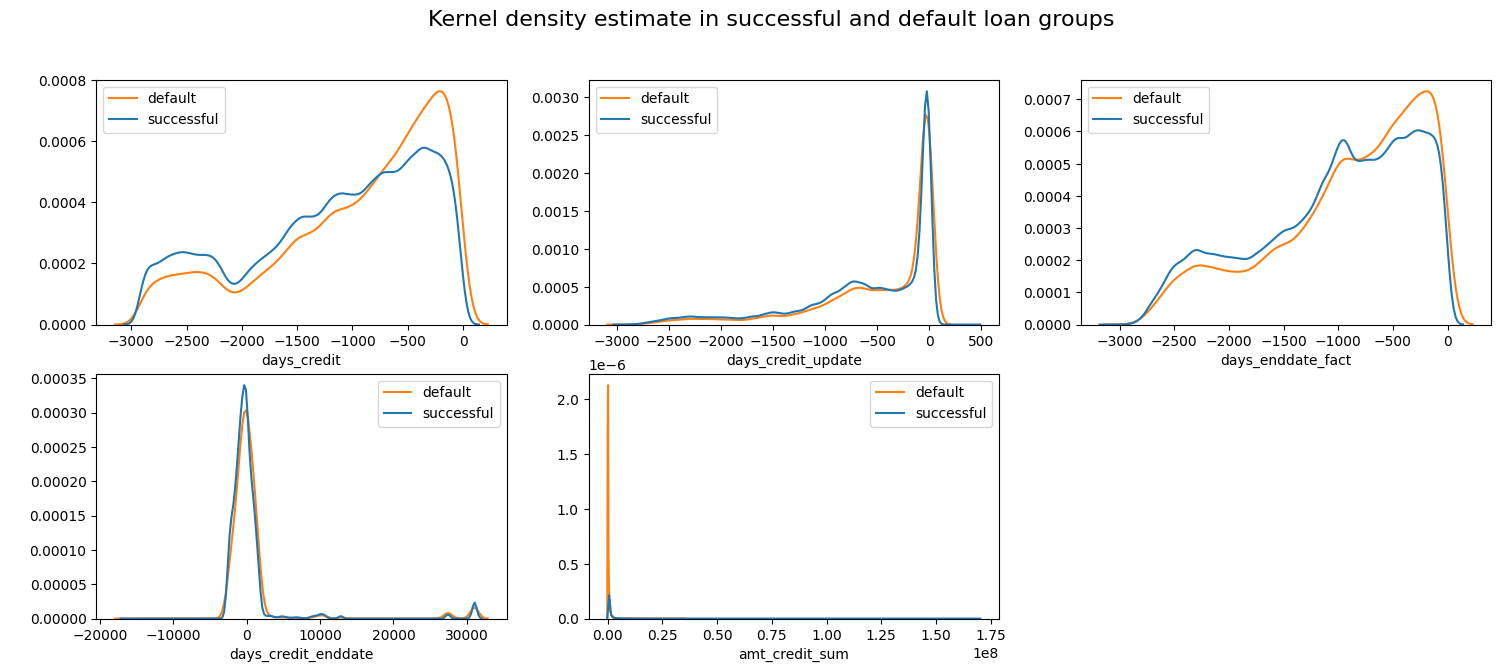

In [23]:
h.plot_density(bureau_merged, 'target', 
            ['days_credit', 'days_credit_update',
             'days_enddate_fact', 'days_credit_enddate', 
             'amt_credit_sum'], 
              2)

#### Categorical variables

In [24]:
h.top_categorical_correlations(bureau_merged[categorical_bureau], 
                             'target', 2)

interval columns not set, guessing: ['target']


,target
credit_type,0.059794
credit_active,0.036203


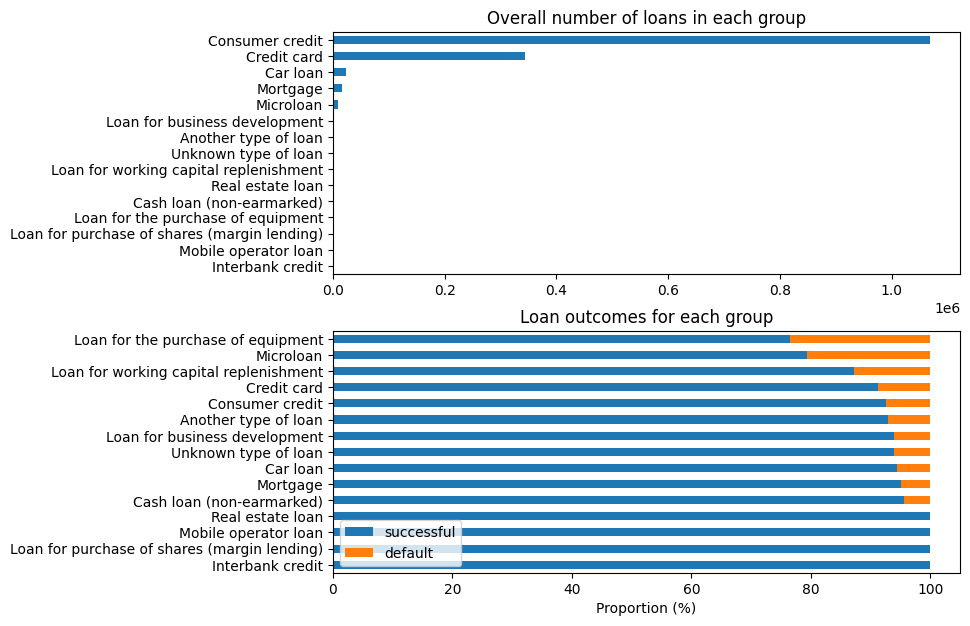

In [25]:
h.ploth_category_counts_percentage(bureau_merged, 'credit_type', 'target')

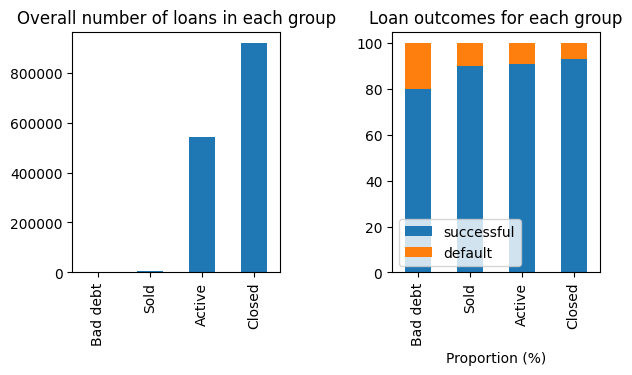

In [26]:
h.plotv_category_counts_percentage(bureau_merged, 
                                 'credit_active', 
                                 'target')

#### Insights

* From numeric features, days of the previous credit applications, update, end and amount of the current credit of Berau data are correlated with the target.
* From categorical features, credit type and credit status are looked important: Loan of purchase of equipment and previous Bad debt status correlate with current application default indication.

### Bureau balance

Similarly to bureau table, this dataset contains information about previous credits, but has monthly updates of the balances. 

In [27]:
bureau_balance = pd.read_csv('bureau_balance.csv')

bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [28]:
bureau_balance_clean = (bureau_balance
                        .pipe(h.print_shape)
                        .pipe(h.copy_data)
                        .pipe(h.lower_column_names)
                        .pipe(h.check_missing_values)
                        .pipe(h.remove_duplicate_rows)
                        .pipe(h.remove_empty_rows)
                        .pipe(h.print_output_shape)
                        )

Original dataframe shape (27299925, 3)
No missing values
Dataframe shape after cleaning (27299925, 3)


There are no missing values and a lot of data entries. The table has sk_id_bureau identifier from the bureau table. Refering to it we will merge this table to the other one.

In [29]:
bureau_balance_merged = bureau_merged[['sk_id_bureau', 'target']] \
                        .merge(bureau_balance_clean, 
                        on='sk_id_bureau', how='left')

bureau_balance_merged.head()

,sk_id_bureau,target,months_balance,status
0,6158904.0,1,-15.0,C
1,6158904.0,1,-16.0,C
2,6158904.0,1,-17.0,0
3,6158904.0,1,-18.0,0
4,6158904.0,1,-19.0,0


Out of the available columsn, status seems to be most informative.

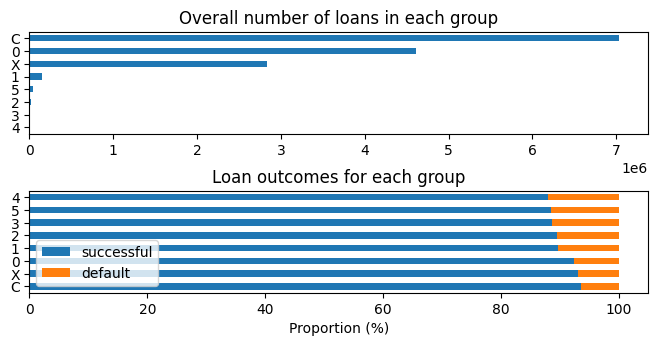

In [30]:
h.ploth_category_counts_percentage(bureau_balance_merged, 'status', 'target')

We see that the status looks similar to an ordinary feature, except that it has two subgroups with letter features - C and X. Metadata file identifies that C means closed, X means status unknown, 0 means no **days past due (DPD)**, 1 means maximal DPD during the month between 1-30, 2 means DPD 31-60 etc. 5 means DPD 120+ or sold or written off. We will flag the unknown group and rename other categories to reflect the DPD status in an ordinal manner.

In [31]:
bureau_balance_merged['unknown_status'] = 0
bureau_balance_merged.loc[bureau_balance_merged['status'] == 'X', 
                          'unknown_status'] = 1 

bureau_balance_merged.replace({'status': {'C': 0,
                                          '0': 1,
                                          '1': 2,
                                          '2': 3, 
                                          '3': 4, 
                                          '4': 5, 
                                          '5': 6,
                                          'X': 7}}, inplace=True)

In [32]:
h.top_categorical_correlations(bureau_balance_merged[['status', 'target']], 'target', 3)

interval columns not set, guessing: ['status', 'target']


,target
status,0.027041


#### Insight

* Increasing numbers of update statuses means worse payment habits - days past due. People having a history of longer days past due (subgroups 4-5) seem to also have more defaults 

### Point of sales and cash loans balance

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

In [33]:
pos_cash_balance = pd.read_csv('POS_CASH_balance.csv')

pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


Original dataframe shape (10001358, 8)
No missing values in ['sk_id_prev', 'sk_id_curr', 'months_balance', 'name_contract_status', 'sk_dpd', 'sk_dpd_def']
Dataframe shape after cleaning (10001358, 8)


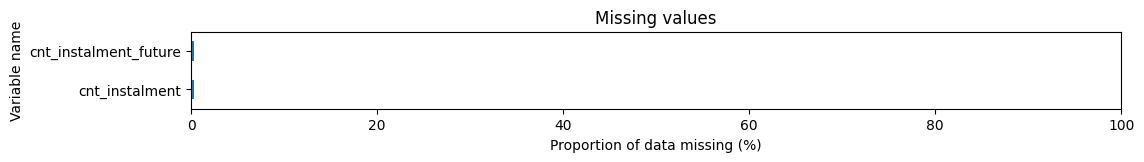

In [34]:
plt.figure(figsize=(12, 1))

pos_cash_balance_clean = (pos_cash_balance
                        .pipe(h.print_shape)
                        .pipe(h.copy_data)
                        .pipe(h.lower_column_names)
                        .pipe(h.check_missing_values)
                        .pipe(h.remove_duplicate_rows)
                        .pipe(h.remove_empty_rows)
                        .pipe(h.print_output_shape)
                        )

Very few missing values in the data. Next, we merge the data and separate numeric and categoricla feature lists.

In [35]:
pos_cash_balance_merged = train_data_clean[['sk_id_curr', 'target']] \
                          .merge(pos_cash_balance_clean,
                           on='sk_id_curr', how='left')

pos_cash_balance_merged.head()

,sk_id_curr,target,sk_id_prev,months_balance,cnt_instalment,cnt_instalment_future,name_contract_status,sk_dpd,sk_dpd_def
0,100002,1,1038818.0,-13.0,24.0,18.0,Active,0.0,0.0
1,100002,1,1038818.0,-16.0,24.0,21.0,Active,0.0,0.0
2,100002,1,1038818.0,-18.0,24.0,23.0,Active,0.0,0.0
3,100002,1,1038818.0,-17.0,24.0,22.0,Active,0.0,0.0
4,100002,1,1038818.0,-5.0,24.0,10.0,Active,0.0,0.0


#### Numeric variables

In [36]:
categorical_pos_cash = ['target', 'name_contract_status']

numeric_pos_cash = ['months_balance', 'cnt_instalment',
                  'cnt_instalment_future', 'sk_dpd',
                  'sk_dpd_def']

h.top_numeric_correlations(pos_cash_balance_merged, 'target', 
                           numeric_pos_cash, 3)

,target
cnt_instalment_future,0.021972
months_balance,0.020147
cnt_instalment,0.018506


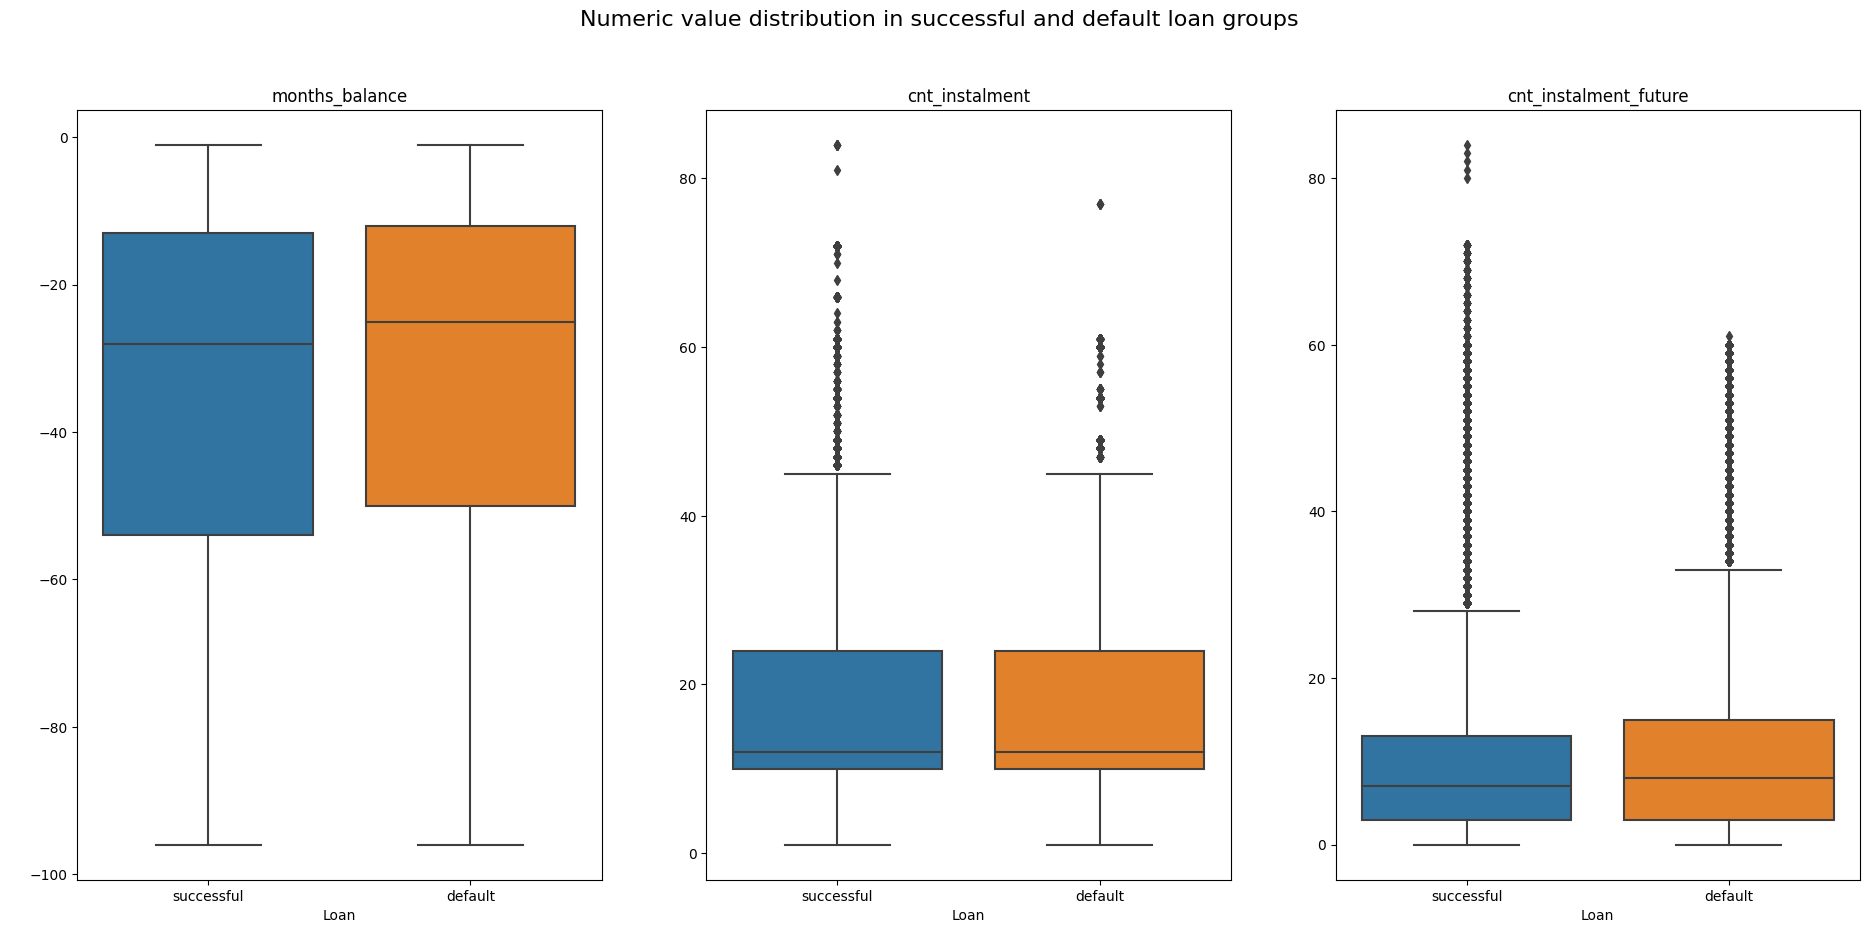

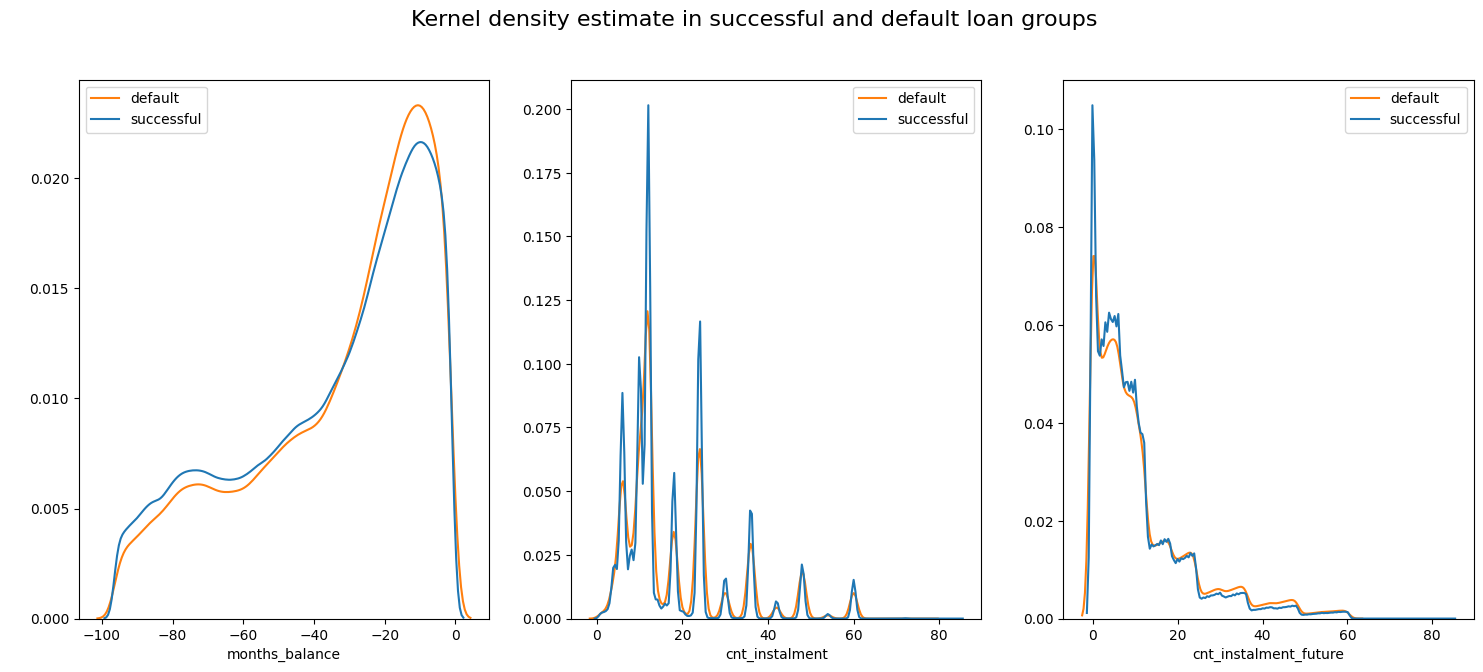

In [37]:
h.plot_boxplots(pos_cash_balance_merged, 'target', 
            ['months_balance', 'cnt_instalment',
                  'cnt_instalment_future'], 1)

h.plot_density(pos_cash_balance_merged, 'target', 
            ['months_balance', 'cnt_instalment',
            'cnt_instalment_future'], 1)

#### Categorical features

In [38]:
h.top_categorical_correlations(pos_cash_balance_merged[categorical_pos_cash], 'target', 2)

interval columns not set, guessing: ['target']


,target
name_contract_status,0.012545


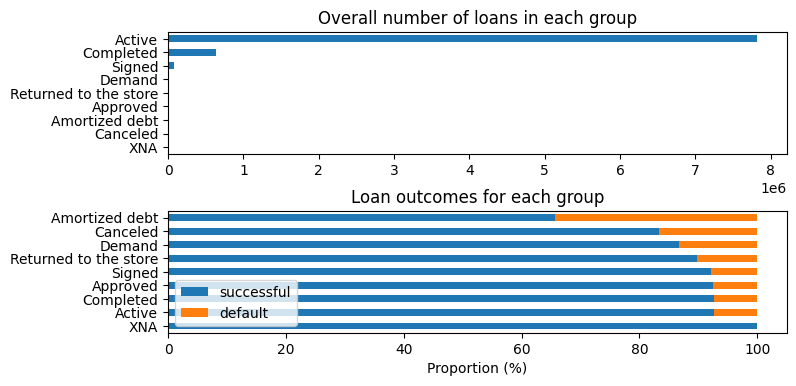

In [39]:
h.ploth_category_counts_percentage(pos_cash_balance_merged, 'name_contract_status', 'target')

Since the status values have sequential order (from approved to closed), we will convert them into ordinal numeric values.

In [40]:
pos_cash_balance_merged.replace({'name_contract_status':
                                 {'XNA': 0,
                                  'Canceled': 1,
                                  'Demand': 2,
                                  'Approved': 3, 
                                  'Signed': 4, 
                                  'Amortized debt': 5, 
                                  'Active': 6,
                                  'Returned to the store': 7,
                                  'Completed': 7}}, inplace=True)

numeric_pos_cash = numeric_pos_cash + ['name_contract_status']

#### Insights

* Number of paid instalments, as well as the remaining ones, showed a correlation with the target, however, the KDE graph did not show prominent patterns.
* Amortized debts had the highest proportion of default loans.

### Credit card balance

Monthly balance snapshots of previous credit cards that the applicant has with
Home Credit.

In [41]:
credit_balance = pd.read_csv('credit_card_balance.csv')

credit_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


Original dataframe shape (3840312, 23)
No missing values in ['sk_id_prev', 'sk_id_curr', 'months_balance', 'amt_balance', 'amt_credit_limit_actual', 'amt_drawings_current', 'amt_payment_total_current', 'amt_receivable_principal', 'amt_recivable', 'amt_total_receivable', 'cnt_drawings_current', 'name_contract_status', 'sk_dpd', 'sk_dpd_def']
Dataframe shape after cleaning (3840312, 23)


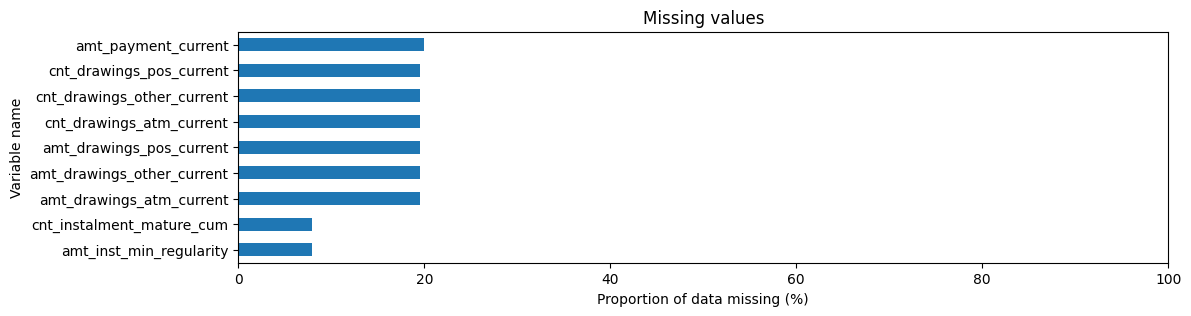

In [42]:
plt.figure(figsize=(12, 3))

credit_balance_clean = (credit_balance
                        .pipe(h.print_shape)
                        .pipe(h.copy_data)
                        .pipe(h.lower_column_names)
                        .pipe(h.check_missing_values)
                        .pipe(h.remove_duplicate_rows)
                        .pipe(h.remove_empty_rows)
                        .pipe(h.print_output_shape)
                        )

In [43]:
credit_balance_merged = train_data_clean[['sk_id_curr', 'target']] \
                          .merge(credit_balance_clean,
                                 on='sk_id_curr', how='left')

#### Numeric variables

In [44]:
categorical_credit_balance= ['target', 'name_contract_status']

numeric_credit_balance = ['amt_balance', 'months_balance',
                          'amt_credit_limit_actual', 'amt_drawings_atm_current',
                          'amt_drawings_current', 'amt_drawings_other_current',
                          'amt_drawings_pos_current', 'amt_inst_min_regularity',
                          'amt_payment_current', 'amt_payment_total_current',
                          'amt_receivable_principal', 'amt_recivable', 
                          'amt_total_receivable', 'cnt_drawings_atm_current', 
                          'cnt_drawings_current', 'cnt_drawings_other_current', 
                          'cnt_drawings_pos_current', 
                          'cnt_instalment_mature_cum', 'sk_dpd',
                          'sk_dpd_def']

h.top_numeric_correlations(credit_balance_merged, 'target', numeric_credit_balance, 3)

,target
amt_balance,0.050098
amt_total_receivable,0.049839
amt_recivable,0.049803


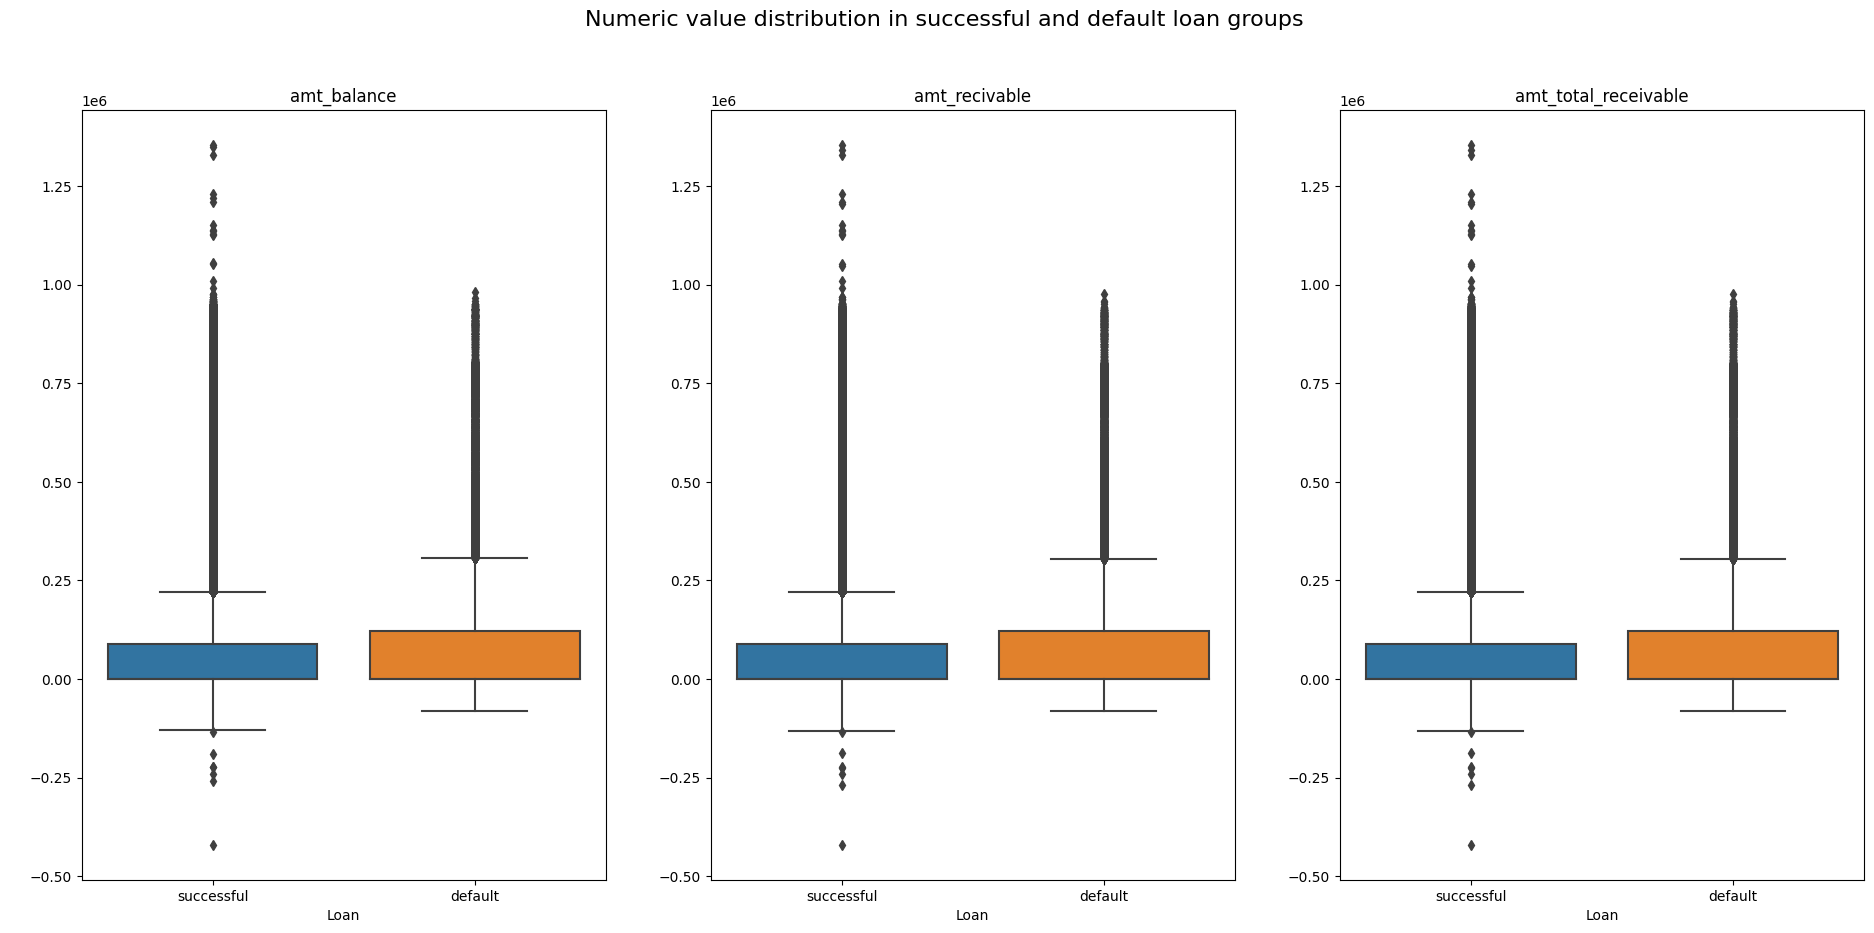

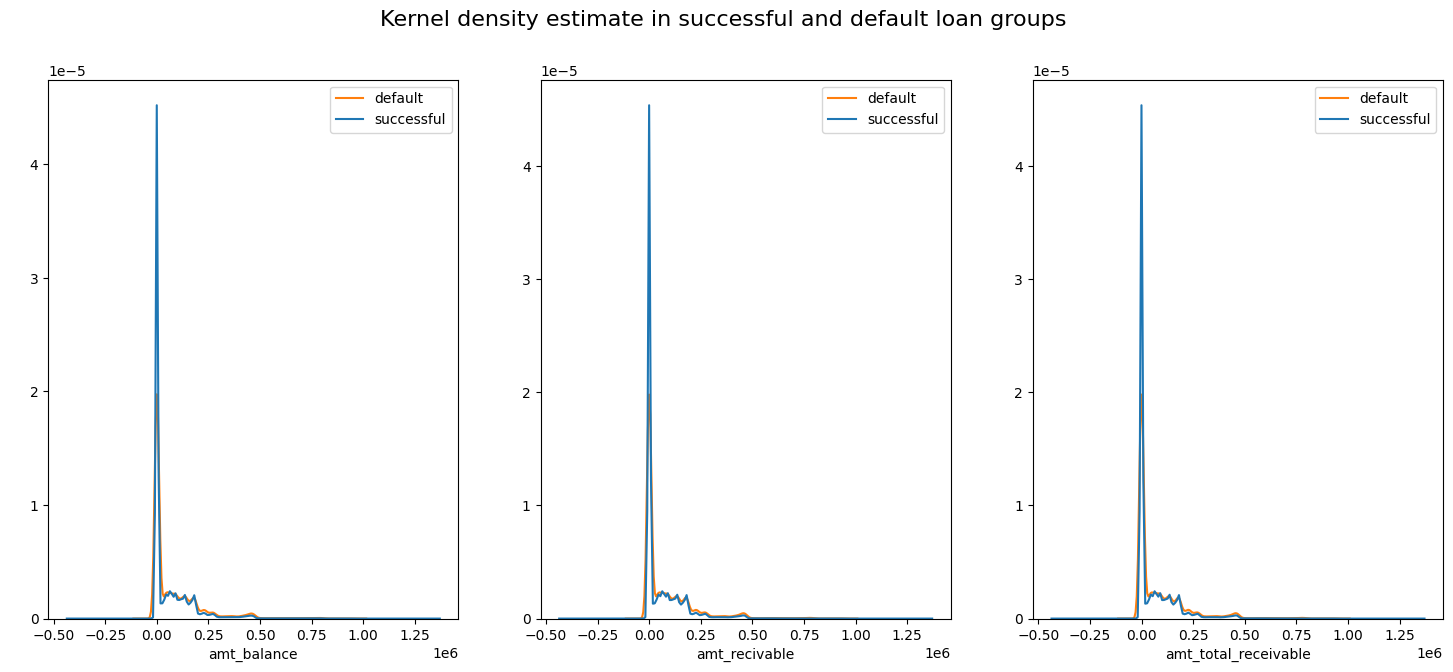

In [45]:
high_corr = ['amt_balance', 'amt_recivable', 
             'amt_total_receivable']

h.plot_boxplots(credit_balance_merged, 'target', 
           high_corr, 1)

h.plot_density(credit_balance_merged, 'target', 
            high_corr, 1)

#### Categorical variables

In [46]:
h.top_categorical_correlations(credit_balance_merged[categorical_credit_balance], 'target', 2)

interval columns not set, guessing: ['target']


,target
name_contract_status,0.015176


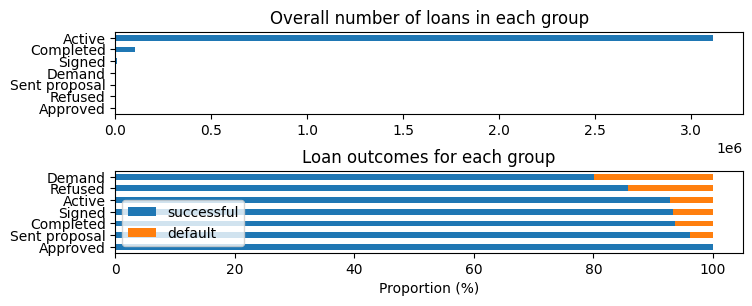

In [47]:
h.ploth_category_counts_percentage(credit_balance_merged, 'name_contract_status', 'target')

In [48]:
credit_balance_merged.replace({'name_contract_status':
                                 {'Refused': 0,
                                  'Demand': 1,
                                  'Sent proposal': 2,
                                  'Approved': 3, 
                                  'Signed': 4, 
                                  'Active': 5, 
                                  'Completed': 6}}, inplace=True)

numeric_credit_balance  = numeric_credit_balance + ['name_contract_status']

#### Insights

* Amount of balance, receivable had the highest correlation with targets. However, the graphs did not show a high difference between the groups which probably identifies that these features are not as important or require engineering.
* The credit status of Demand seems to have the highest proportion of default loans.

### Previous application

All previous applications for Home Credit loans of clients who have loans in our sample.

In [49]:
prev_application = pd.read_csv('previous_application.csv')

prev_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Original dataframe shape (1670214, 37)
No missing values in ['sk_id_prev', 'sk_id_curr', 'name_contract_type', 'amt_application', 'weekday_appr_process_start', 'hour_appr_process_start', 'flag_last_appl_per_contract', 'nflag_last_appl_in_day', 'name_cash_loan_purpose', 'name_contract_status', 'days_decision', 'name_payment_type', 'code_reject_reason', 'name_client_type', 'name_goods_category', 'name_portfolio', 'name_product_type', 'channel_type', 'sellerplace_area', 'name_seller_industry', 'name_yield_group']
Dataframe shape after cleaning (1670214, 37)


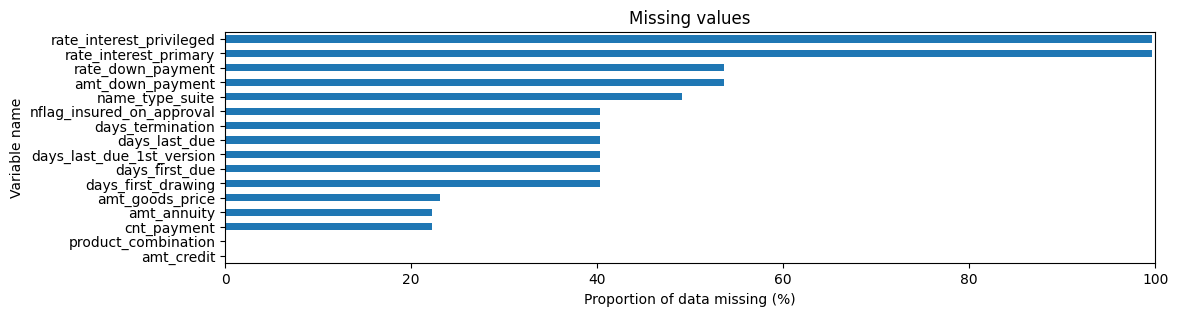

In [50]:
plt.figure(figsize=(12, 3))

prev_application_clean = (prev_application
                        .pipe(h.print_shape)
                        .pipe(h.copy_data)
                        .pipe(h.lower_column_names)
                        .pipe(h.check_missing_values)
                        .pipe(h.remove_duplicate_rows)
                        .pipe(h.remove_empty_rows)
                        .pipe(h.print_output_shape)
                        )

In [51]:
prev_application_merged = train_data_clean[['sk_id_curr', 'target']] \
                          .merge(prev_application_clean,
                          on='sk_id_curr', how='left')

#### Numeric variables

In [52]:
categorical_prev_application = ['target', 'name_contract_type',
                                'weekday_appr_process_start',
                                'hour_appr_process_start', 
                                'flag_last_appl_per_contract', 
                                'nflag_last_appl_in_day', 
                                'name_cash_loan_purpose', 
                                'name_contract_status',
                                'name_payment_type', 'code_reject_reason',
                                'name_type_suite', 'name_client_type',
                                'name_goods_category', 'name_portfolio', 
                                'name_product_type', 'channel_type', 
                                'name_seller_industry', 'name_yield_group', 
                                'product_combination', 
                                'nflag_insured_on_approval']

numeric_prev_application = ['amt_annuity', 'amt_application', 
                            'amt_credit', 'amt_down_payment',
                            'amt_goods_price', 'rate_down_payment', 
                            'rate_interest_primary',
                            'rate_interest_privileged', 
                            'days_decision', 'sellerplace_area', 
                            'cnt_payment', 'days_first_drawing', 
                            'days_first_due', 'days_last_due_1st_version',
                            'days_last_due', 'days_termination']

h.top_numeric_correlations(prev_application_merged, 'target', 
                         numeric_prev_application, 5)

,target
days_decision,0.039901
days_first_drawing,0.031154
cnt_payment,0.030480
rate_interest_privileged,0.028640
rate_down_payment,0.026111


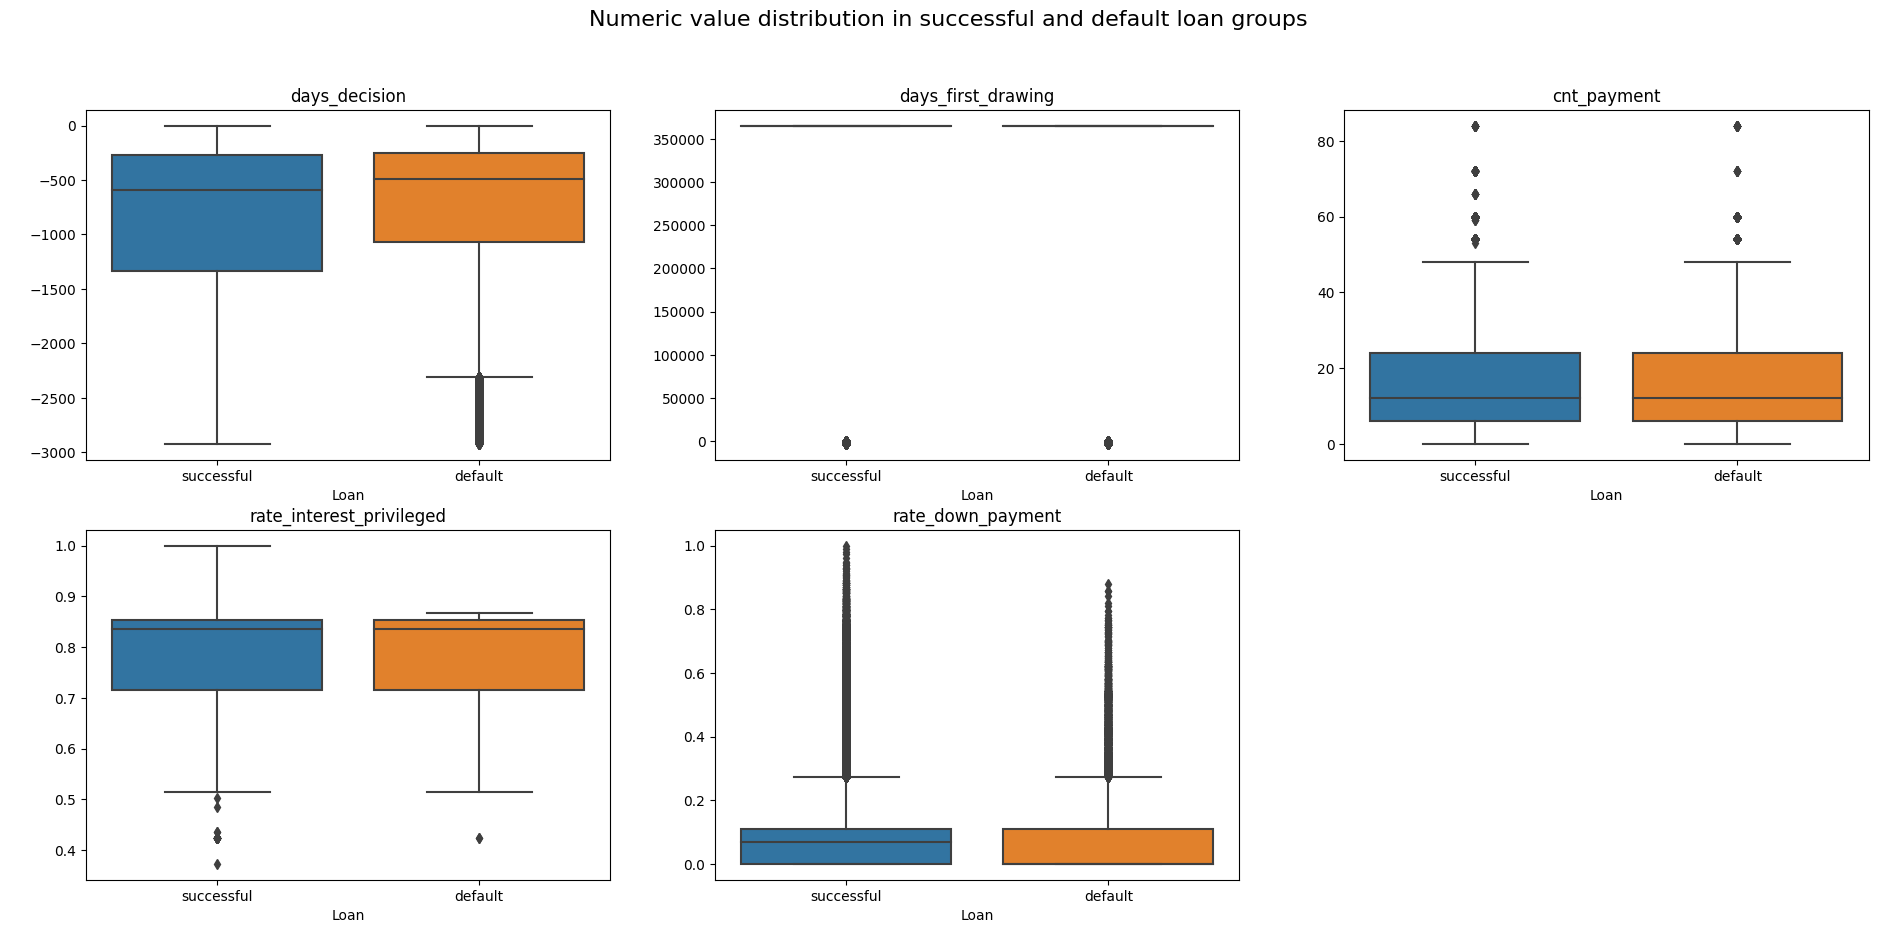

In [53]:
high_corr = ['days_decision', 'days_first_drawing', 
             'cnt_payment', 'rate_interest_privileged',
            'rate_down_payment']

h.plot_boxplots(prev_application_merged, 'target', 
               high_corr, 2)

In the *days_first_drawing*, we see a very large value, 365243, which seems to be either see an erroneous value or an identifier of a specific status. After additional investigation, we discovered that other days' columns also have this particular value. Since we do not have a way to confirm what it means, we will replace these values with NaNs.

In [54]:
prev_application_merged.loc[prev_application_merged['days_first_drawing'] \
                            == 365243, 'days_first_drawing'] = np.nan

prev_application_merged.loc[prev_application_merged['days_first_due'] \
                            == 365243, 'days_first_due'] = np.nan

prev_application_merged.loc[prev_application_merged['days_last_due'] \
                            == 365243, 'days_last_due'] = np.nan

prev_application_merged.loc[prev_application_merged['days_last_due_1st_version'] \
                            == 365243, 'days_last_due_1st_version'] = np.nan

prev_application_merged.loc[prev_application_merged['days_termination'] \
                            == 365243, 'days_termination'] = np.nan

prev_application_merged.loc[prev_application_merged['sellerplace_area'] \
                            == 4000000, 'sellerplace_area'] = np.nan

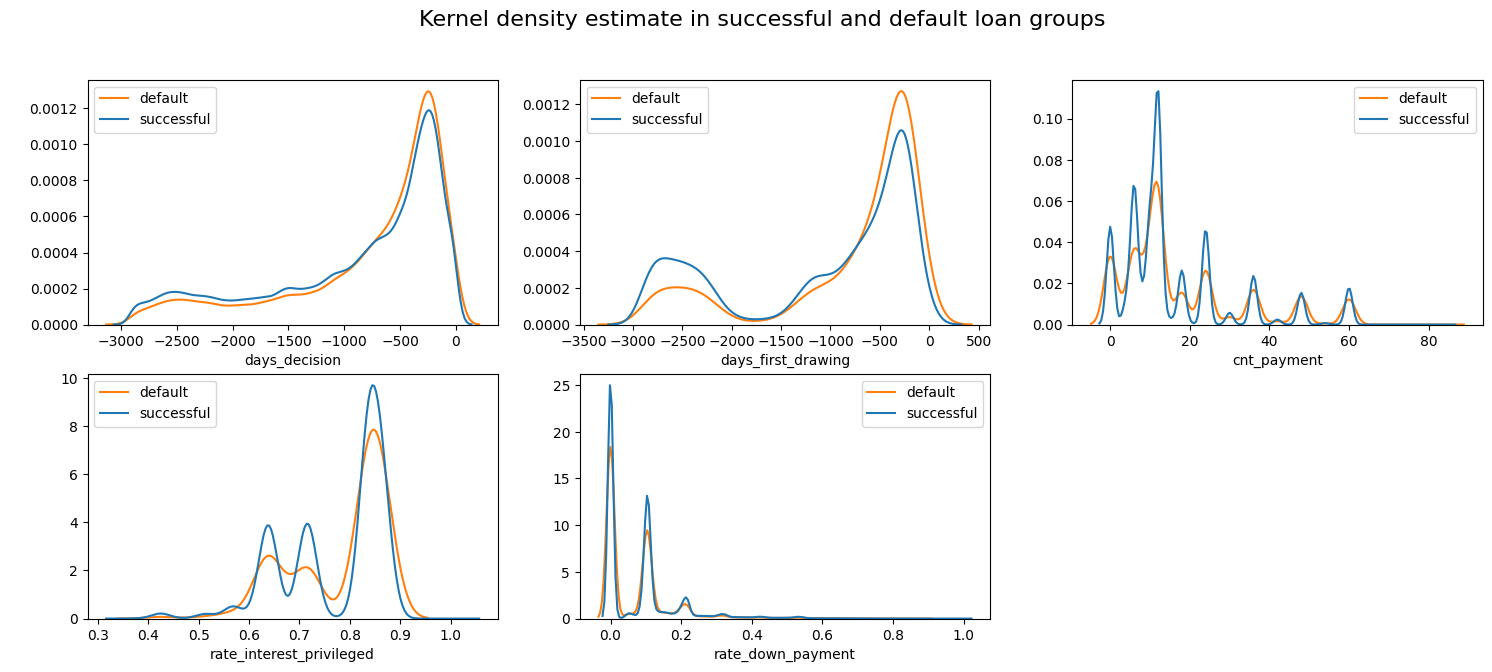

In [55]:
h.plot_density(prev_application_merged, 'target', 
            high_corr, 2)

#### Categorical variables

In [56]:
h.top_categorical_correlations(prev_application_merged[categorical_prev_application], 
                               'target', 3)

interval columns not set, guessing: ['target', 'hour_appr_process_start', 'nflag_last_appl_in_day', 'nflag_insured_on_approval']


,target
code_reject_reason,0.082538
product_combination,0.073340
name_product_type,0.066534


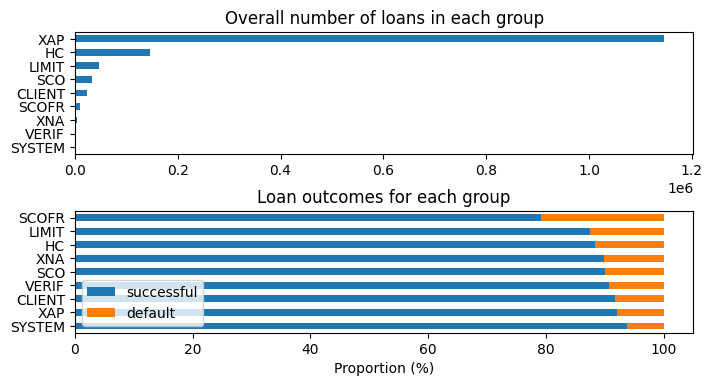

In [57]:
h.ploth_category_counts_percentage(prev_application_merged, 
                                   'code_reject_reason', 'target')

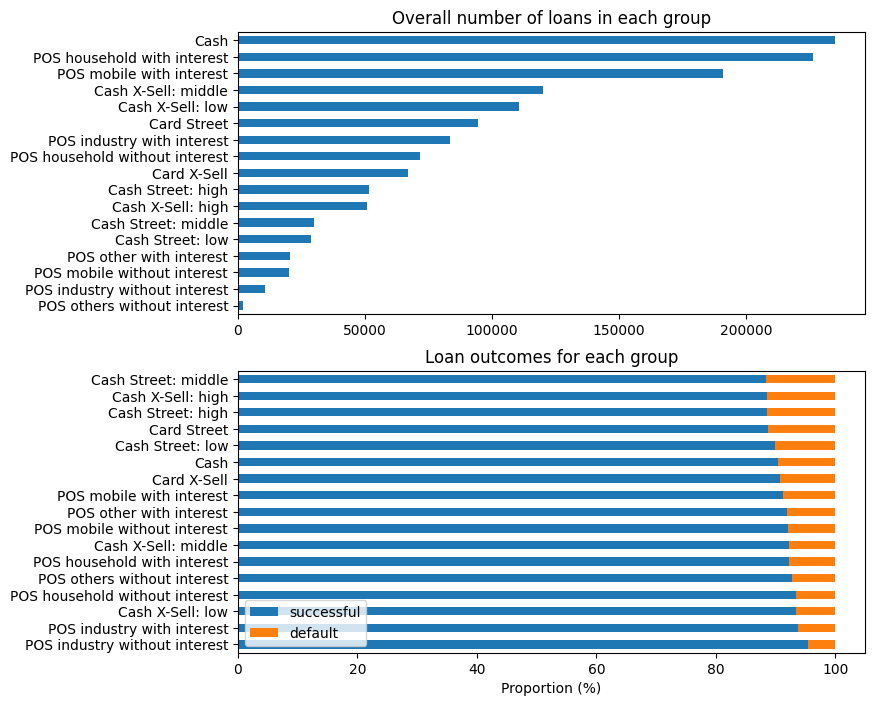

In [58]:
h.ploth_category_counts_percentage(prev_application_merged,
                                   'product_combination', 'target')

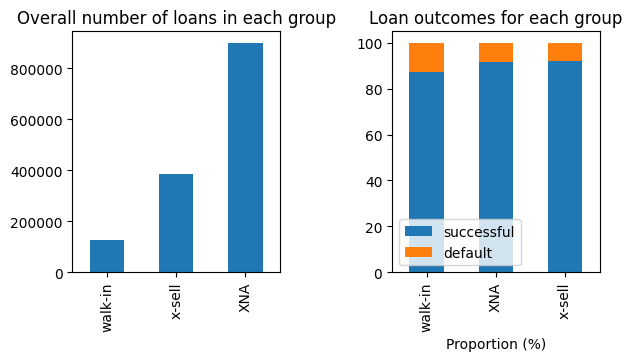

In [59]:
h.plotv_category_counts_percentage(prev_application_merged, 
                                   'name_product_type', 'target')

#### Insights

* Numeric correlations are relatively low and did not reveal differences in subgroups
* From categorical features previous rejections reason, product_combination and product name time were most informative.

### Installment payments

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. It provides us with useful information about the course of previous loans payments.

In [60]:
payments = pd.read_csv('installments_payments.csv')

payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


Original dataframe shape (13605401, 8)
No missing values in ['sk_id_prev', 'sk_id_curr', 'num_instalment_version', 'num_instalment_number', 'days_instalment', 'amt_instalment']
Dataframe shape after cleaning (13605401, 8)


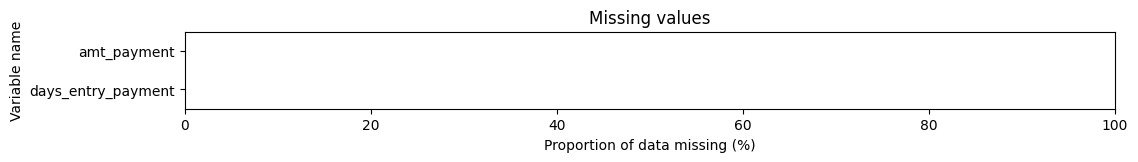

In [61]:
plt.figure(figsize=(12, 1))

payments_clean = (payments
                .pipe(h.print_shape)
                .pipe(h.copy_data)
                .pipe(h.lower_column_names)
                .pipe(h.check_missing_values)
                .pipe(h.remove_duplicate_rows)
                .pipe(h.remove_empty_rows)
                .pipe(h.print_output_shape)
                )

The last 2 columns of this dataset contain information about the expected payment, *amt_instalment*, and the actual payment *amt_payment*. Based on this information, we will derive a new column, in which the  This will be our second goal of the project.

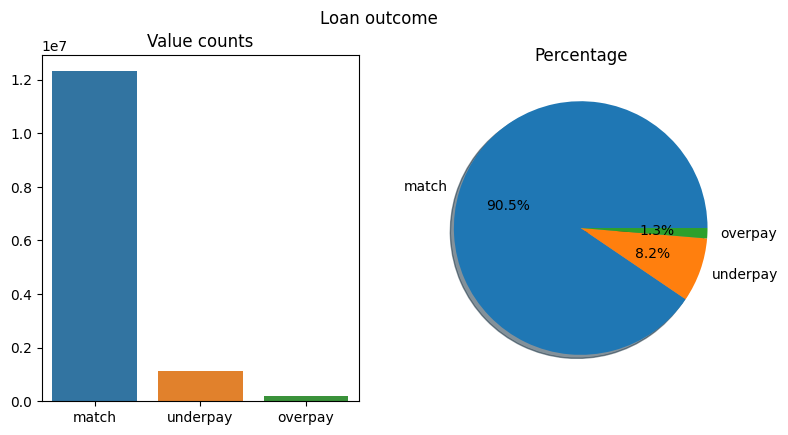

In [62]:
payments_clean['payment_difference'] =  payments_clean.amt_instalment \
                                        - payments_clean.amt_payment

payments_clean['underpay'] = (payments_clean['payment_difference'] > 50).astype('int')
payments_clean['overpay'] = (payments_clean['payment_difference'] < -50).astype('int')

payments_clean['payment_difference_category'] = "match"

payments_clean.loc[payments_clean['underpay'] == 1, 
                   'payment_difference_category'] = "underpay"

payments_clean.loc[payments_clean['overpay'] == 1, 
                   'payment_difference_category'] = "overpay"

h.plot_outcome_distribution(payments_clean, 
                          'payment_difference_category',
                          ['match', 'underpay', 'overpay'])

Similarly, we will derive delays betweeen expected and actual payment.

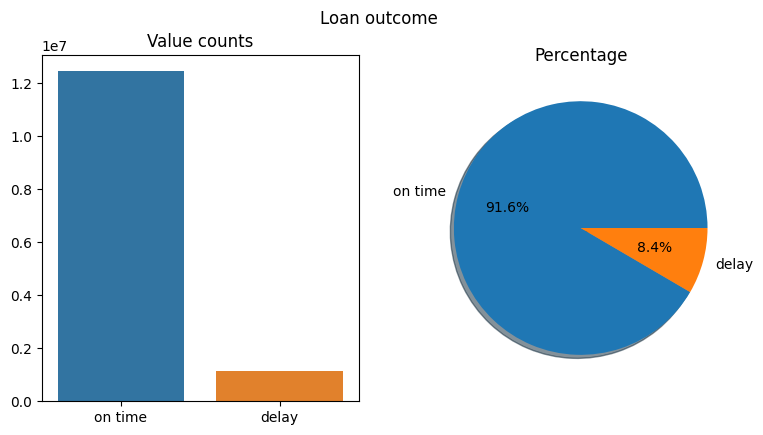

In [63]:
payments_clean['day_payment_difference'] =  payments_clean.days_instalment \
                                            - payments_clean.days_entry_payment
payments_clean['payment_delay'] = 0

payments_clean.loc[payments_clean['day_payment_difference'] < 0, 
                   'payment_delay'] = 1

h.plot_outcome_distribution(payments_clean, 
                          'payment_delay',
                          ['on time', 'delay'])

Similarly, we will check if users tend to fall into the same behaviours for the current loans if they have a history of troubles with previous payments.

In [64]:
payments_merged = train_data_clean[['sk_id_curr', 'target']] \
                  .merge(payments_clean, on='sk_id_curr', how='left')

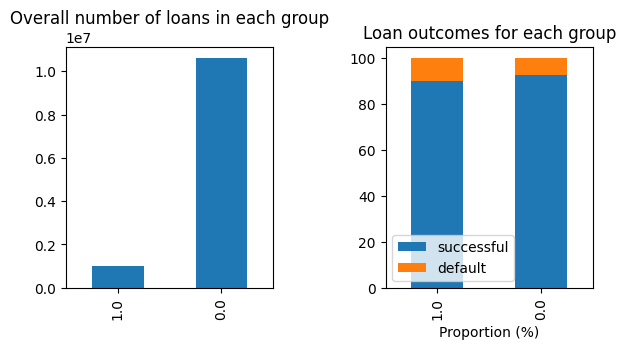

In [65]:
categorical_payments = ['payment_difference_category']

numeric_payments = payments_merged \
                   .columns[~payments_merged.columns \
                            .isin(categorical_payments
                            +['sk_id_curr', 'target', 
                              'sk_id_prev'])].tolist()

h.plotv_category_counts_percentage(payments_merged, 'payment_delay', 'target')

#### Insights

* Similarly to the current loan applications, 8% of loans seem to have payment difficulties
* Seems like a history of previous payment issues might be informative to the current default outcome: a larger proportion of past defaulters have default loans as well

## Saving adjusted data

Before moving to feature engineering, we will save the data with adjusted base features.

In [66]:
train_data_features = train_data_clean.copy()

train_data_features.to_pickle("./home_credit_base_features.pkl")  

with open("home_credit_base_feature_lists.pkl", "wb") as f:
    pkl.dump((categorical_train, numeric_train), f)

## Feature engineering

Below, the strategy of feature engineering is described:
* **External source feature calculations.** Based on the exploratory analysis, the highest correlations with the target variable were from the application train, in particular the ext_source_3. We will therefore try to boost these features by dividing, multiplying them etc. together.
* **Two or multiple feature combinations.** Were sensible, calculations of two or multiple features are applied. 
* **Feature aggregates grouped by id.** Some tables provide information about previous credits with other institutions as well as loans within HomeCredit. Each applicant has multiple entries. Statistical summaries of each feature will be derived for each loaner: sum, mean, max, min, variance, first last etc. Which of these functions is most useful will be derived on column bases.
* **Feature aggregates sorted in time.** Some tables contain information about the previous loan payments and balances of accounts. The same ids usually have multiple entries. Also, each of these tables has some identification of the time of entries. Therefore, for these features we will also create some statistic summary features: mean, max, etc using aggregation across time.
* **Feature aggregates across n feature sorted in time.** Based on the presumption that more recent information reflects the financial situation of a person better, we will also try to derive aggregates of the last *n* latest or oldest entries sorted based on time.

Since for the EDA purposes we added target variable to the dataframes, we are going to drop this reoccuring column.

In [67]:
bureau_merged.drop('target', axis=1, inplace=True)
bureau_balance_merged.drop('target', axis=1, inplace=True)
credit_balance_merged.drop('target', axis=1, inplace=True)
prev_application_merged.drop('target', axis=1, inplace=True)
payments_merged.drop('target', axis=1, inplace=True)
pos_cash_balance_merged.drop('target', axis=1, inplace=True)

### Application data

In [68]:
train_data_features \
= h.calculate_multi_feature_combinations(train_data_features,
                                                   ['ext_source_1',
                                                    'ext_source_2',
                                                    'ext_source_3'],
                                                   ['mean', 'max', 'min', 
                                                    'sum', 'multi', 'var'])

train_data_features \
= h.calculate_2feature_combinations(train_data_features, 
                                ['amt_credit', 
                                'amt_annuity'], 
                                ['ratio'])

Created feature ext_source_cols_mean
Created feature ext_source_cols_max
Created feature ext_source_cols_min
Created feature ext_source_cols_sum
Created feature ext_source_cols_multi
Created feature ext_source_cols_var
Created feature amt_credit_amt_annuity_ratio


Since information about apartments yielded some high correlation, we will sum them and create to create a feature.

In [69]:
apartments_avg_features =  ['apartments_avg', 'basementarea_avg',
                            'years_beginexpluatation_avg', 'years_build_avg', 
                            'commonarea_avg', 'elevators_avg',
                            'entrances_avg', 'floorsmax_avg', 
                            'floorsmin_avg', 'landarea_avg', 
                            'livingapartments_avg',  'livingarea_avg', 
                            'nonlivingapartments_avg', 'nonlivingarea_avg']

train_data_features \
= h.calculate_multi_feature_combinations(train_data_features,
                                       apartments_avg_features,
                                       ['sum'])

Created feature apartments_a_cols_sum


In [70]:
apartments_mode_features = ['apartments_mode', 'basementarea_mode', 
                            'years_beginexpluatation_mode', 'years_build_mode', 
                            'commonarea_mode', 'elevators_mode', 
                            'entrances_mode', 'floorsmax_mode', 
                            'floorsmin_mode', 'landarea_mode', 
                            'livingapartments_mode', 'livingarea_mode', 
                            'nonlivingapartments_mode', 'nonlivingarea_mode', 
                            'totalarea_mode']

train_data_features \
= h.calculate_multi_feature_combinations(train_data_features,
                                       apartments_mode_features,
                                       ['sum']) 

Created feature apartments_mo_cols_sum


In [71]:
apartments_medi_features = ['apartments_medi', 'basementarea_medi',
                            'years_beginexpluatation_medi', 'years_build_medi', 
                            'commonarea_medi', 'elevators_medi', 
                            'entrances_medi', 'floorsmax_medi', 
                            'floorsmin_medi', 'landarea_medi', 
                            'livingapartments_medi', 'livingarea_medi', 
                            'nonlivingapartments_medi', 'nonlivingarea_medi']

train_data_features \
= h.calculate_multi_feature_combinations(train_data_features,
                                       apartments_medi_features,
                                       ['sum']) 

Created feature apartments_me_cols_sum


Adjust the categorical and numeric feature list.

In [72]:
categorical_train, numeric_train \
= h.adjust_feature_lists(train_data_features, categorical_train,  {'sk_id_curr', 'target'})

### Bureau and bureau balance

Bureau balance data has information about the course of previous applications. As it is associated with the bureau data via the sk_id_bureau, we will use it to add the aggregated features to the main data.

First, for bureau_balance we will convert months to positive numbers for easier interpretation.

In [73]:
bureau_balance_merged['months_balance'] \
= bureau_balance_merged['months_balance'] * -1

bureau_balance_merged['year_balance'] \
= bureau_balance_merged['months_balance'] / 12

Next, we will perform calculations across the status values which were converted to numerical before - the smaller the value, the better the status.

In [74]:
bureau_balance_status \
= h.calculate_feature_aggregates(bureau_balance_merged, 
                              ['status'], 
                              ['mean','max','first'], 
                              'sk_id_bureau', 
                              'months_balance')

bureau_balance_year \
= h.calculate_feature_aggregates(bureau_balance_merged, 
                              ['year_balance'], 
                              ['first'], 
                              'sk_id_bureau', 
                              'months_balance')

Now we are going to add these features to the main bureau table.

In [75]:
bureau_merged = bureau_merged \
                .merge(bureau_balance_status, on='sk_id_bureau', how='left') \
                .merge(bureau_balance_year, on='sk_id_bureau', how='left')

In [76]:
bureau_merged['flag_overdue'] = 0
bureau_merged.loc[bureau_merged['credit_day_overdue'] > 0, 'flag_overdue'] = 1

For remaining bureau  feature we will also perform aggregation across different historical loans. 

In [77]:
bureau_merged_mean \
= h.calculate_feature_aggregates(bureau_merged, 
                              ['credit_day_overdue',
                               'cnt_credit_prolong', 
                               'amt_annuity',
                              'status_mean'], 
                               ['mean'], 'sk_id_curr', 
                               'days_credit')

bureau_merged_max \
= h.calculate_feature_aggregates(bureau_merged, 
                              ['credit_day_overdue',
                               'amt_credit_max_overdue',
                               'cnt_credit_prolong', 
                               'amt_credit_sum', 
                               'amt_credit_sum_limit',
                               'amt_annuity',
                               'days_enddate_fact',
                              'status_max'], 
                               ['max'], 'sk_id_curr', 
                               'days_credit')

bureau_merged_sum \
= h.calculate_feature_aggregates(bureau_merged, 
                              ['credit_day_overdue',
                               'amt_credit_max_overdue',
                               'cnt_credit_prolong', 
                               'amt_credit_sum', 
                               'amt_credit_sum_debt',
                               'amt_credit_sum_limit', 
                               'amt_credit_sum_overdue',
                              'flag_overdue'], 
                               ['sum'], 'sk_id_curr', 
                               'days_credit')

bureau_merged_min \
= h.calculate_feature_aggregates(bureau_merged, 
                              ['days_credit_update'], 
                               ['min'], 'sk_id_curr', 
                               'days_credit')

bureau_merged_first \
= h.calculate_feature_aggregates(bureau_merged, 
                                ['credit_active', 
                                'credit_currency', 
                                'credit_type',
                                'year_balance_first',
                                'days_credit_enddate',
                                'days_enddate_fact'], 
                                ['first'], 'sk_id_curr', 
                                'days_credit')

Finally, we will merge newly created features to the feature table.

In [78]:
bureau_features = bureau_merged_mean \
                .merge(bureau_merged_max, on='sk_id_curr', how='left') \
                .merge(bureau_merged_sum, on='sk_id_curr', how='left') \
                .merge(bureau_merged_min, on='sk_id_curr', how='left') \
                .merge(bureau_merged_first, on='sk_id_curr', how='left') 

In [79]:
categorical_bureau = ['sk_id_curr', 'target', 'credit_active_first',
                      'credit_currency_first', 'credit_type_first']

categorical_bureau, numeric_bureau \
= h.adjust_feature_lists(bureau_features, categorical_bureau, {'sk_id_curr', 'target'})

### POS and cash balance

This and other tables describe the behaviour of the costumer over time and have one or another identification of the time. Therefore, features here will be calculated over time by taking the last/first entries or aggregation of a couple of last/first entries.

In [80]:
pos_cash_agg2 = h.calculate_time_feature_aggregates(pos_cash_balance_merged, 
                                                  numeric_pos_cash,
                                                  'sk_id_curr', 
                                                  'months_balance',
                                                  ['sum'], 2, 'pos')

pos_cash_agg5 = h.calculate_time_feature_aggregates(pos_cash_balance_merged, 
                                                  numeric_pos_cash,
                                                  'sk_id_curr', 
                                                  'months_balance', 
                                                  ['sum'], 5, 'pos')

Merge data into one dataframe.

In [81]:
pos_cash_features = pos_cash_agg2 \
                   .merge(pos_cash_agg5, on='sk_id_curr', how='left')

In [82]:
numeric_pos_cash = pos_cash_features.columns.tolist()

### Credit card balance features

Similarly, the credit card balance features will be derived.

The number of total drawings as well as other ratios might be informative for the outcome prediction.

In [83]:
credit_balance_features \
= h.calculate_multi_feature_combinations(credit_balance_merged,
                                       ['amt_drawings_atm_current',
                                        'amt_drawings_current',
                                        'amt_drawings_other_current',
                                        'amt_drawings_pos_current'],
                                        ['sum'])

credit_balance_features \
= h.calculate_multi_feature_combinations(credit_balance_features,
                                        ['cnt_drawings_atm_current', 
                                        'cnt_drawings_current',
                                        'cnt_drawings_other_current', 
                                        'cnt_drawings_pos_current',
                                        'cnt_instalment_mature_cum' ],
                                        ['sum'])

credit_balance_features \
= h.calculate_2feature_combinations(credit_balance_features, 
                                 ['amt_balance', 
                                 'amt_credit_limit_actual'], 
                                 ['ratio'])

Created feature amt_drawings_atm_curre_cols_sum
Created feature cnt_drawings_atm_curre_cols_sum
Created feature amt_balance_amt_credit_limit_actual_ratio


In [84]:
credit_balance_agg2 \
= h.calculate_time_feature_aggregates(credit_balance_merged, 
                                    numeric_credit_balance,
                                    'sk_id_curr', 
                                    'months_balance', 
                                    ['sum'], 2, 'cre')

credit_balance_agg5 \
= h.calculate_time_feature_aggregates(credit_balance_merged, 
                                    numeric_credit_balance,
                                    'sk_id_curr', 
                                    'months_balance', 
                                    ['sum'], 5, 'cre')

numeric_credit_balance.remove('months_balance')

numeric_credit_balance = numeric_credit_balance \
                         + ['amt_drawings_atm_curre_cols_sum',
                           'cnt_drawings_atm_curre_cols_sum',
                           'amt_balance_amt_credit_limit_actual_ratio']

credit_balance_merged_sum_mean_max \
= h.calculate_feature_aggregates(credit_balance_features, 
                               numeric_credit_balance, 
                               ['sum', 'mean', 'max'],
                               'sk_id_curr', 
                               'months_balance')

Merging data and adjusting feature names.

In [85]:
credit_features = credit_balance_merged_sum_mean_max \
                  .merge(credit_balance_agg2, on='sk_id_curr', how='left') \
                  .merge(credit_balance_agg5, on='sk_id_curr', how='left') 

In [86]:
categorical_credit = ['sk_id_curr']

categorical_credit, numeric_credit \
= h.adjust_feature_lists(credit_features, categorical_credit, {'sk_id_curr'})

### Installment payment features

Since these are entries acorss multiple time points.

In [87]:
payments_agg2 \
= h.calculate_time_feature_aggregates(payments_merged, 
                                    numeric_payments,
                                    'sk_id_curr', 
                                    'days_entry_payment', 
                                    ['sum', 'mean', 'max'], 
                                    2, 'pay')

payments_agg5 \
= h.calculate_time_feature_aggregates(payments_merged, 
                                    numeric_payments,
                                    'sk_id_curr', 
                                    'days_entry_payment', 
                                    ['sum', 'mean', 'max'],
                                    5, 'pay')

In [88]:
numeric_payments.remove('days_entry_payment')

payments_numeric \
= h.calculate_feature_aggregates(payments_merged, 
                               numeric_payments, 
                               ['mean', 'max', 'min', 
                                'sum', 'first', 'last'],
                                'sk_id_curr', 
                                'days_entry_payment')

payments_categorical \
= h.calculate_feature_aggregates(payments_merged, 
                               categorical_payments, 
                               ['first'],
                                'sk_id_curr', 
                                'days_entry_payment')

In [89]:
payments_features = payments_numeric \
                    .merge(payments_categorical, on='sk_id_curr', how='left') \
                    .merge(payments_agg2, on='sk_id_curr', how='left') \
                    .merge(payments_agg5, on='sk_id_curr', how='left') 

In [90]:
categorical_payments = payments_categorical.columns

categorical_payments, numeric_payments \
= h.adjust_feature_lists(payments_features, categorical_payments, {'sk_id_curr'})

### Previous application

The previous application commitment might describe the users' current ability to pay the current debt. Therefore, from this table, we will derive quite some features.

First, we will derive ratios and differences between the loaner's income, the amount asked and the amount granted. 

In [91]:
prev_application_merged \
= h.calculate_2feature_combinations(prev_application_merged,
                                  ['amt_application', 'amt_credit'], 
                                  ['diff'])

prev_application_merged \
= h.calculate_2feature_combinations(prev_application_merged,
                                  ['amt_goods_price', 'amt_credit'], 
                                  ['ratio', 'diff'])

prev_application_merged \
= h.calculate_2feature_combinations(prev_application_merged,
                                  ['amt_credit', 'amt_down_payment'], 
                                  ['ratio', 'diff'])

numeric_prev_application = numeric_prev_application + \
                            ['amt_application_amt_credit_diff', 
                             'amt_goods_price_amt_credit_ratio',
                             'amt_goods_price_amt_credit_diff', 
                             'amt_credit_amt_down_payment_ratio', 
                             'amt_credit_amt_down_payment_diff']

Created feature amt_application_amt_credit_diff
Created feature amt_goods_price_amt_credit_ratio
Created feature amt_goods_price_amt_credit_diff
Created feature amt_credit_amt_down_payment_ratio
Created feature amt_credit_amt_down_payment_diff


For categorical features, we will take the information from the latest application which will be determined using the *days_decision* variable (other time indication columns had a lot of missing values).

In [92]:
categorical_prev_application.remove('target')

prev_application_categorical \
= h.calculate_feature_aggregates(prev_application_merged, 
                               categorical_prev_application, 
                               ['first'],
                                'sk_id_curr', 
                                'days_decision')

For numeric features, we will calculate aggregates over 2 and 5 first and last entries of the previous application.

In [93]:
prev_application_agg2 \
= h.calculate_time_feature_aggregates(prev_application_merged, 
                                    numeric_prev_application,
                                   'sk_id_curr', 
                                   'days_decision', 
                                    ['sum', 'mean', 'max'], 
                                    2, 'prev_app')

prev_application_agg5 \
= h.calculate_time_feature_aggregates(prev_application_merged,
                                    numeric_prev_application,
                                    'sk_id_curr', 
                                    'days_decision', 
                                    ['sum', 'mean', 'max'], 
                                    5, 'prev_app')

Merging data, adjusting feature lists.

In [94]:
prev_application_features = prev_application_categorical \
                            .merge(prev_application_agg2, on='sk_id_curr', how='left') \
                            .merge(prev_application_agg5, on='sk_id_curr', how='left') 

In [95]:
categorical_prev_application = prev_application_categorical.columns

categorical_prev_application , numeric_prev_application \
= h.adjust_feature_lists(prev_application_features, categorical_prev_application, {'sk_id_curr'})

## Merging and saving features

The constructed feature will be merged into one dataframe. 

In [96]:
train_features = train_data_features \
                  .merge(bureau_features, on='sk_id_curr', how='left')\
                  .merge(pos_cash_features, on='sk_id_curr', how='left')\
                  .merge(credit_features, on='sk_id_curr', how='left')\
                  .merge(payments_features, on='sk_id_curr', how='left')\
                  .merge(prev_application_features, on='sk_id_curr', how='left')

In addition, the categorical and numeric feature name lists will be added together to save them for the model training.

In [97]:
categorical_features = categorical_train + categorical_bureau \
                      + categorical_credit + categorical_payments \
                      + categorical_prev_application 

numeric_features = numeric_train + numeric_bureau \
                   + numeric_credit + numeric_payments \
                   + numeric_pos_cash + numeric_prev_application

Finally, we will save the data as well as feature lists for further model training.

In [98]:
train_features.to_pickle("./home_credit_features.pkl")  

with open("home_credit_feature_lists.pkl", "wb") as f:
    pkl.dump((categorical_features, numeric_features), f)

## Final conclusions

* Here we investigate 7 tables containing information about the current and previous loans, their applications and payments within Home Credit and Credit Bureau.
* The most significant features seem to be the ones from applications tables as they showed the highest correlations and some difference in data distribution between default and now default groups. 
* Overall, all observed correlations between features and targets were relatively low (below 0.2).
* Various features were engineered: combinations of 2 or more features, aggregates across ids as well as time were summarised into one value.